In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.hub
from functools import partial


from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg, Mlp, Block
import numpy as np
import torch
import torch_xla
import torch_xla.core.xla_model as xm

import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
import os

import dataset
import torch
import warnings

import pandas as pd
import numpy as np
import torch.nn as nn

from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
torch.manual_seed(42)
os.environ['PJRT_DEVICE'] = 'TPU' 

warnings.filterwarnings("ignore")
libc = ctypes.CDLL("libc.so.6")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.hub
from functools import partial


from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg, Mlp, Block
import numpy as np
import torch

import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
import os

import torch
import warnings

import pandas as pd
import numpy as np
import torch.nn as nn
import timm
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

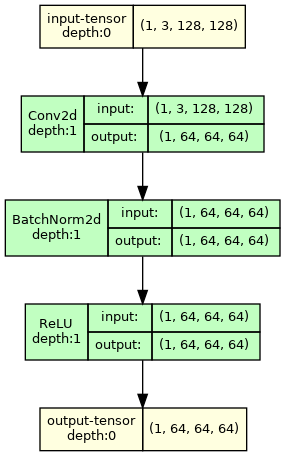

In [66]:
import torchvision
from torchview import draw_graph
import graphviz

resnet = torchvision.models.resnet.resnet50(pretrained=True)
input_block = nn.Sequential(*list(resnet.children()))[:3]

graphviz.set_jupyter_format('png')
model_graph = draw_graph(input_block, input_size=(1,3,128,128))
model_graph.visual_graph

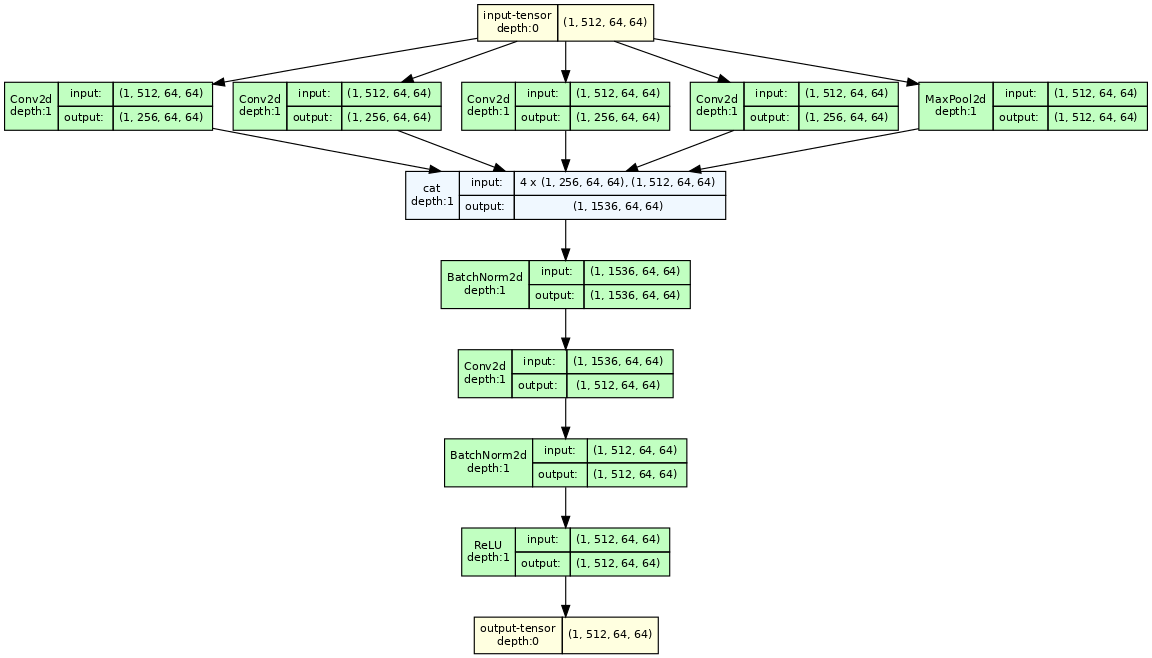

In [67]:
class Atrous_Convolution(nn.Module):
    def __init__(self, img_size = 64, in_channels=32, out_channels=64, dilation_rate=0, kernel_size = 3, padding = 'same'):
        super().__init__()
        self.img_size = img_size
        self.dilation_rate = dilation_rate
        self.kernel_size = kernel_size
        self.padding = padding
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv = nn.ModuleList([nn.Conv2d(in_channels = self.in_channels, 
                                   out_channels = self.out_channels//2, 
                                   kernel_size = self.kernel_size[i], 
                                   padding = self.padding,
                                   dilation = self.dilation_rate[i]) for i in range(len(dilation_rate))]
                                 )
        self.batchnorm = nn.BatchNorm2d(self.in_channels*2 + self.in_channels)
        self.batchnorm_1 = nn.BatchNorm2d(self.out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1)
        self.relu = nn.ReLU()
        self.one_cross_one_conv = nn.Conv2d(in_channels = self.out_channels*2 + self.in_channels, out_channels = self.out_channels, kernel_size = 1, dilation = 1, padding = 'same')
    def forward(self, x):
        op = []
        for block in self.conv:
            op.append(block(x))
        op.append(self.maxpool(x))
        op = torch.cat(op, axis = 1)
        op = self.batchnorm(op)
        op = self.one_cross_one_conv(op)
        op = self.batchnorm_1(op)
        op = self.relu(op)
        return op
atr_conv = Atrous_Convolution(img_size = 32, in_channels = 512, out_channels = 512, dilation_rate = [1, 6, 12, 18], kernel_size = [1,3,3,3])
model_graph = draw_graph(atr_conv, input_size=(1,512,64, 64), expand_nested=True)
model_graph.visual_graph


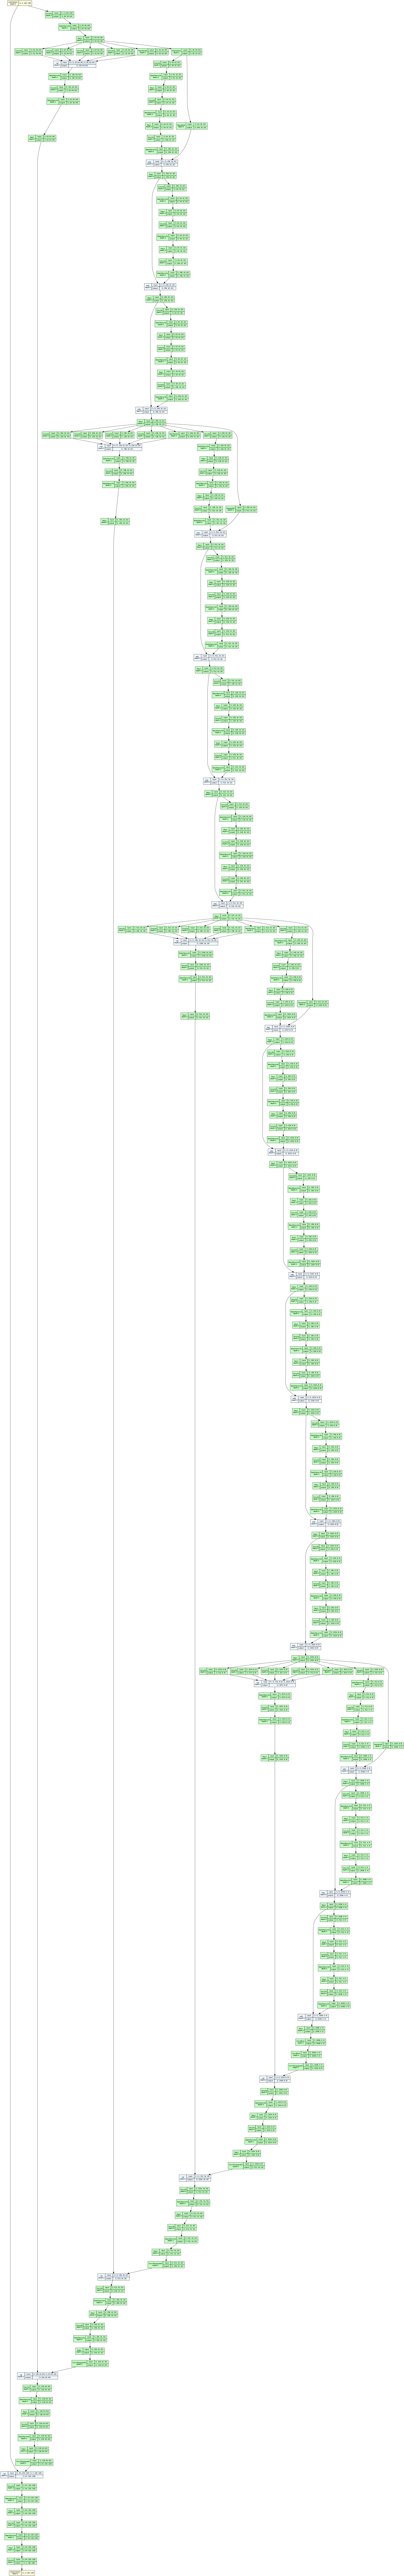

In [68]:
import torch
import torch.nn as nn
import torchvision
resnet = torchvision.models.resnet.resnet50(pretrained=True)


class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """

        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=2):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        atrous_convolutions = []
        atrous_convolutions.append(Atrous_Convolution(in_channels = 1024, out_channels = 1024, dilation_rate = [1, 6, 12, 18], kernel_size = [1,3,3,3]))
        atrous_convolutions.append(Atrous_Convolution(in_channels = 512, out_channels = 512, dilation_rate = [1, 6, 12, 18], kernel_size = [1,3,3,3]))
        atrous_convolutions.append(Atrous_Convolution(in_channels = 256, out_channels = 256, dilation_rate = [1, 6, 12, 18], kernel_size = [1,3,3,3]))
        # atrous_convolutions.append(Atrous_Convolution(in_channels = 128, out_channels = 128, dilation_rate = [1, 6, 12, 18], kernel_size = [1,3,3,3]))
        atrous_convolutions.append(Atrous_Convolution(in_channels = 64, out_channels = 64, dilation_rate = [1, 6, 12, 18], kernel_size = [1,3,3,3]))

        self.atrous_convolutions = nn.ModuleList(atrous_convolutions)
        
        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)
        attr = []
        
        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            # print(i)
            if i < 5:
                x = block(x, self.atrous_convolutions[i-1](pre_pools[key]))
            else:
                x = block(x, pre_pools[key])
            
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

model = UNetWithResnet50Encoder()
# model.load_state_dict(torch.load('./final_unet_model.pth'))
# inp = torch.rand((2, 3, 512, 512))
import torchvision
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')
model_graph = draw_graph(model, input_size=(1,3,128,128))
model_graph.visual_graph

In [69]:
class_names = ['background', 'building']
select_classes = ['background', 'building']
class_rgb_values = [[0], [1]]
# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0], [1]]


In [70]:
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    # print(label.shape)
    # print(label_values)
    for colour in label_values:
        # print(colour)
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values : values assignes to each position in one hot encoded vector

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x
    
def to_tensor(x, **kwargs):
    return torch.from_numpy(x.transpose(2, 0, 1).astype('float32'))
    
def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(A.Lambda(image=preprocessing_fn))
    _transform.append(A.Lambda(image=to_tensor, mask=to_tensor))
        
    return A.Compose(_transform)

In [73]:
import os
import torch
import pandas as pd
# from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import skimage.io as io
import os
import albumentations
import albumentations.pytorch
import random
class Custom_Dataset(Dataset):
    def __init__(self, img_dir, annotation_file, class_rgb_values = None, transforms = None, preprocessing = None):
        self.img_dir = img_dir
        self.annotation_file = annotation_file
        self.coco = COCO(annotation_file)
        self.img_ids = self.coco.getImgIds()
        self.transforms = transforms
        self.preprocessing = preprocessing
        self.class_rgb_values = class_rgb_values
        
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = (np.array(io.imread(img_path)))
        
        annotation_ids = self.coco.getAnnIds(imgIds = img_info['id'])
        annotations = self.coco.loadAnns(annotation_ids)

        mask = np.zeros((img_info['height'], img_info['width']))

        # random.shuffle(annotations)
        # probability = random.randint(0, len(annotations))
        # annotations = annotations[:probability]
        
        for annotation in annotations:
            # Get the segmentation polygons
            segmentation = annotation['segmentation']
            
            # If the segmentation is a list of polygons
            if isinstance(segmentation, list):
                rles = maskUtils.frPyObjects(segmentation, img_info['height'], img_info['width'])
                rle = maskUtils.merge(rles)
                mask += maskUtils.decode(rle)
            # If the segmentation is a RLE
            else:
                mask = maskUtils.merge([mask, maskUtils.decode(maskUtils.frPyObjects(segmentation, img_info['height'], img_info['width']))])

        mask = one_hot_encode(np.expand_dims(mask, axis = -1), self.class_rgb_values).astype('float')
        
        if self.transforms:
            transformed = self.transforms(image = image, mask = mask)
            image = transformed['image']
            mask = transformed['mask']
            
        mask[mask > 1] = 0
        mask = (mask).permute(2, 0, 1)
        sample = {'img' : image, "mask" : mask}
        
        return sample

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the albumentations transformation
transform = A.Compose([
    A.CropNonEmptyMaskIfExists(
        height=128,  # int
        width=128,  # int
        ignore_values=[0],  # list[int] | None
        ignore_channels=None,  # list[int] | None
        always_apply=False,  # bool | None
        p=1.0,  # float
    ),
    # A.PadIfNeeded(min_height=512, min_width=512, p=1),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(p = 0.5),
    ToTensorV2()
])

val_transform = A.Compose([
    # A.PadIfNeeded(min_height=512, min_width=512, p=1),
    A.CropNonEmptyMaskIfExists(
        height=128,  # int
        width=128,  # int
        ignore_values=[0],  # list[int] | None
        ignore_channels=None,  # list[int] | None
        always_apply=False,  # bool | None
        p=1.0,  # float
    ),
    ToTensorV2()
])

loading annotations into memory...
Done (t=2.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
torch.Size([3, 128, 128])
torch.Size([2, 128, 128])


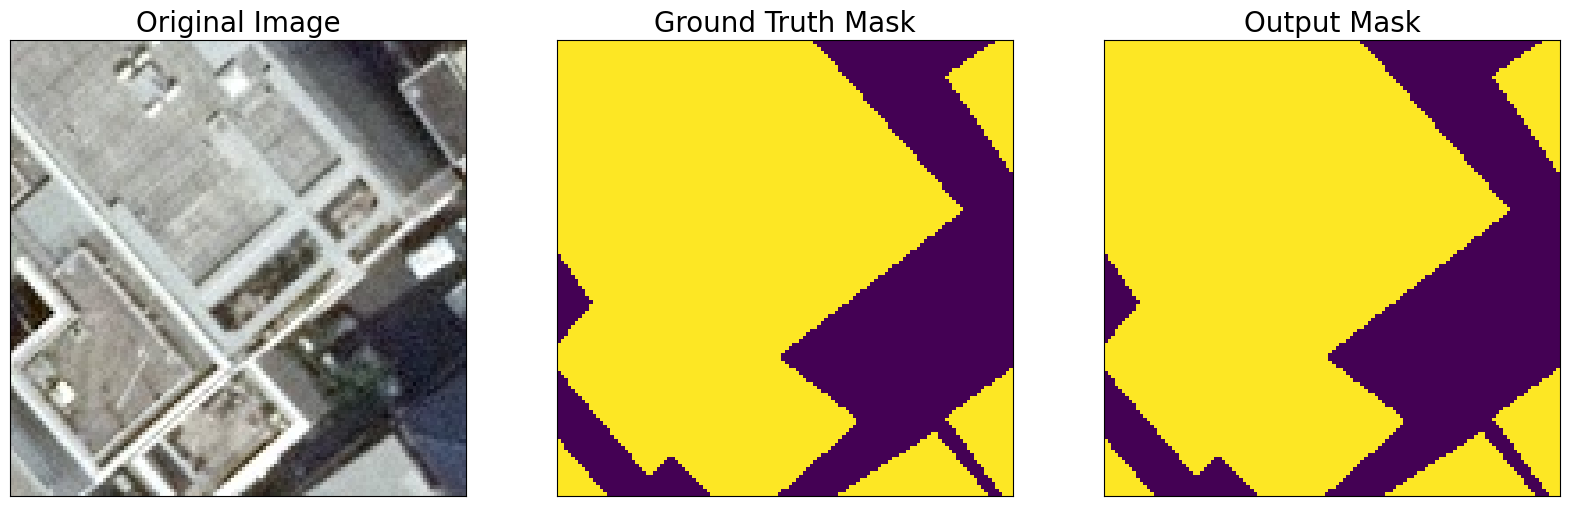

In [74]:
# dataset = Custom_Dataset('/home/shashank/IEEE/train//', '/home/shashank/IEEE/train/train.json')
dataset = Custom_Dataset('/home/shashank/IEEE/train/', '/home/shashank/IEEE/train/train.json', transforms = transform, class_rgb_values=select_class_rgb_values)
v_dataset = Custom_Dataset('/home/shashank/IEEE/val/', '/home/shashank/IEEE/val/val.json', transforms = val_transform, class_rgb_values=select_class_rgb_values)

sample = dataset.__getitem__(0)
print(sample['img'].shape)
print(sample['mask'].shape)
visualize(
    original_image = sample['img'].permute(1, 2, 0).detach().cpu().numpy(),
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(sample['mask'].permute(1, 2, 0).detach().cpu().numpy()), select_class_rgb_values),
    output_mask = reverse_one_hot(sample['mask'].permute(1, 2, 0).detach().cpu().numpy())
)

In [75]:
print(sample['mask'].shape)

torch.Size([2, 128, 128])


torch.Size([4, 3, 128, 128])


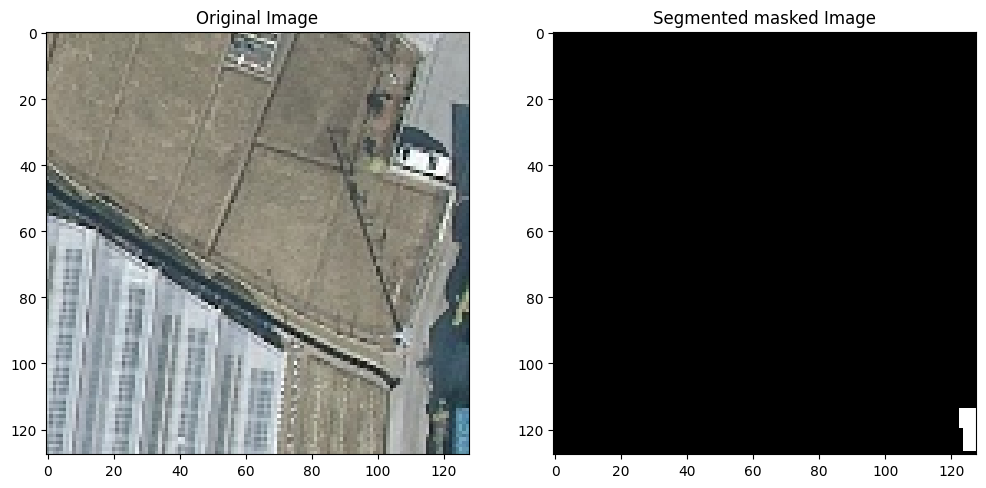

In [76]:
datal = torch.utils.data.DataLoader(dataset, batch_size = 4)
for step, batch in enumerate(datal):
    break

print(batch['img'].shape)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(batch['img'][1].permute(1,2,0))
ax[0].set_title('Original Image')

ax[1].imshow(reverse_one_hot(batch['mask'][1].permute(1, 2, 0).detach().cpu().numpy()), alpha=1.0, cmap='grey')
ax[1].set_title('Segmented masked Image')

plt.show()

In [77]:
batch['mask'].unique()

tensor([0., 1.], dtype=torch.float64)

In [81]:
import segmentation_models_pytorch as smp

def dice_loss(inp, target):
    inp = torch.sigmoid(inp)
    smooth = 1.0

    iflat = inp.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, inp, target):
        if not (target.size() == inp.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), inp.size()))

        max_val = (-inp).clamp(min=0)
        loss = inp - inp * target + max_val + \
            ((-max_val).exp() + (-inp - max_val).exp()).log()

        invprobs = F.logsigmoid(-inp * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, inp, target):
        loss = self.alpha*self.focal(inp, target) - torch.log(dice_loss(inp, target))
        return loss.mean()

def dice(pred, targs):
    pred = (pred>0).float()
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

def IoU(pred, targs):
    pred = (pred>0).float()
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)
    
criterion = MixedLoss(10.0, 2.0)

inp1 = torch.randn((4, 2, 128, 128))
inp2= torch.randn((4, 2, 128, 128))
loss = criterion(inp1, inp2)

print(loss)

tensor(nan)


In [58]:
def reduce_fn(vals):
    # take average
    return sum(vals) / len(vals)
def train_one_epoch(epoch, epochs, model, train_dataloader, valid_dataloader, criterion, scheduler, device, optimizer):
    train_loss = []
    train_iou = []
    valid_loss = []
    valid_iou = []

    model.train()
    scheduler.step()
    # xm.master_print('reached')
    for step, batch in tqdm(enumerate(train_dataloader), desc=f'Epoch {epoch+1}/{epochs} (Train)', unit='batch'):
        image = batch['img'].to(device)
        mask = batch['mask'].to(device)
                               
        optimizer.zero_grad()

        outputs = model(image)
        loss = criterion(outputs, mask)

        loss.sum().backward()
        iou_score = IoU(outputs, mask)
        xm.optimizer_step(optimizer)
        loss_reduced = xm.mesh_reduce('loss_reduce',loss,reduce_fn) 
        iou_score_reduced = xm.mesh_reduce('iou_reduce',iou_score,reduce_fn)
        
        if step%100 == 0:
            xm.master_print(f'Train_Batch: {step}, loss: {loss_reduced}  iou_score: {iou_score_reduced}')

        train_loss.append(loss_reduced.detach().cpu().numpy())
        train_iou.append(iou_score_reduced.detach().cpu().numpy())
        gc.collect()

    model.eval()
    with torch.no_grad():
        for step, batch in tqdm(enumerate(valid_dataloader), desc=f'Epoch {epoch+1}/{epochs} (Train)', unit='batch'):
            image = batch['img'].to(device)
            mask = batch['mask'].to(device)
            outputs = model(image)

            loss = criterion(outputs, mask)
            iou_score = IoU(outputs, mask)
            loss_reduced = xm.mesh_reduce('loss_reduce',loss,reduce_fn) 
            iou_score_reduced = xm.mesh_reduce('iou_reduce',iou_score,reduce_fn)
            
            if step%100 == 0:
                xm.master_print(f'Train_Batch: {step}, loss: {loss_reduced}  iou_score: {iou_score_reduced}')
                gc.collect

            valid_loss.append(loss_reduced.detach().cpu().numpy())
            valid_iou.append(iou_score_reduced.detach().cpu().numpy())
            
    if epoch % 2 == 0:
        visualize(
            original_image = image[0].permute(1, 2, 0).detach().cpu().numpy(),
            ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask[0].permute(1, 2, 0).detach().cpu().numpy()), select_class_rgb_values),
            output_mask = reverse_one_hot(torch.sigmoid(outputs[0]).permute(1, 2, 0).detach().cpu().numpy())
        )
    return np.mean(train_loss), np.mean(valid_loss), np.mean(train_iou), np.mean(valid_iou)

In [82]:
def data():

    train_transform = A.Compose([
        A.CropNonEmptyMaskIfExists(
            height=128,  # int
            width=128,  # int
            ignore_values=[0],  # list[int] | None
            ignore_channels=None,  # list[int] | None
            always_apply=True,  # bool | None
            p=1.0,  # float
        ),
        A.RandomBrightnessContrast(p=0.2),
        A.HorizontalFlip(p = 0.5),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.CropNonEmptyMaskIfExists(
            height=128,  # int
            width=128,  # int
            ignore_values=[0],  # list[int] | None
            ignore_channels=None,  # list[int] | None
            always_apply=True,  # bool | None
            p=1.0,  # float
        ),
        # A.PadIfNeeded(min_height=512, min_width=512, p=1),
        ToTensorV2()
    ])
    
    ##Train Dataset
    train_dataset = Custom_Dataset('/home/shashank/IEEE/train/', '/home/shashank/IEEE/train/train.json', transforms = transform, class_rgb_values=select_class_rgb_values)

    ##Test Dataset
    test_dataset = Custom_Dataset('/home/shashank/IEEE/val/', '/home/shashank/IEEE/val/val.json', transforms = val_transform, class_rgb_values=select_class_rgb_values)
    
    ##Sampler
    train_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    train_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = True
                                                                    )
    
    ##Train Dataloader
    dataloader_train = torch.utils.data.DataLoader(train_dataset,
                                                    batch_size=16,
                                                    sampler = train_sampler,
                                                    drop_last = True,
                                                    num_workers=4,
                                                    pin_memory = True)
    
    
    ##Sampler
    valid_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    test_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = False
                                                                    )
    ##Test Dataloader
    dataloader_test = torch.utils.data.DataLoader(test_dataset,
                                                  sampler = valid_sampler,
                                                  batch_size=16,
                                                  drop_last = True,
                                                  num_workers=4,
                                                 )
    return dataloader_train, dataloader_test

loading annotations into memory...
loading annotations into memory...
loading annotations into memory...
loading annotations into memory...
Done (t=1.26s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
Done (t=1.29s)
creating index...
Done (t=1.36s)
creating index...
index created!
loading annotations into memory...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


Epoch 1/30 (Train): 0batch [00:00, ?batch/s]

Done (t=0.18s)
creating index...
index created!
Done (t=1.75s)
creating index...
index created!
loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
kalua
num_training_steps = 27, world_size=4


Epoch 1/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 2.687803683499669  iou_score: 0.4136430020677031


Epoch 1/30 (Train): 59batch [07:11,  7.31s/batch]
Epoch 1/30 (Train): 0batch [00:00, ?batch/s]atch]
Epoch 1/30 (Train): 59batch [07:11,  7.32s/batch]
Epoch 1/30 (Train): 59batch [07:12,  7.32s/batch]
Epoch 1/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 1.9686797061622556  iou_score: 0.5890943154368808

Epoch 1/30 (Train): 1batch [00:24, 24.35s/batch]

Epoch 1/30 (Train): 14batch [00:25,  1.79s/batch]





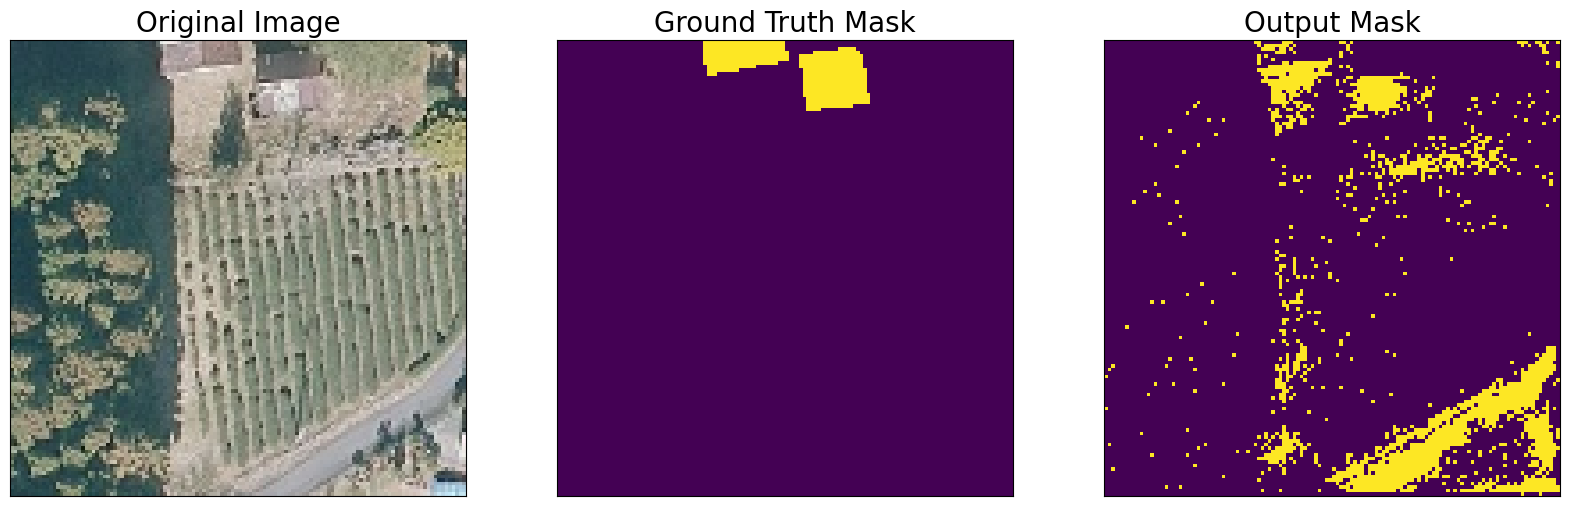

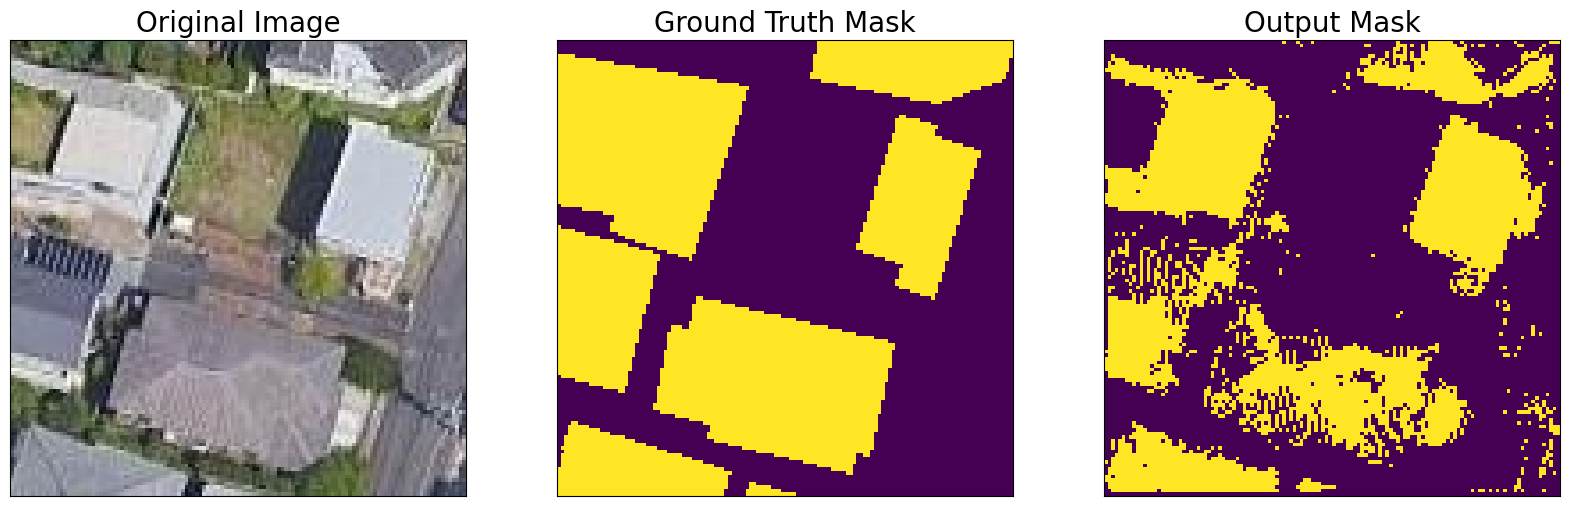

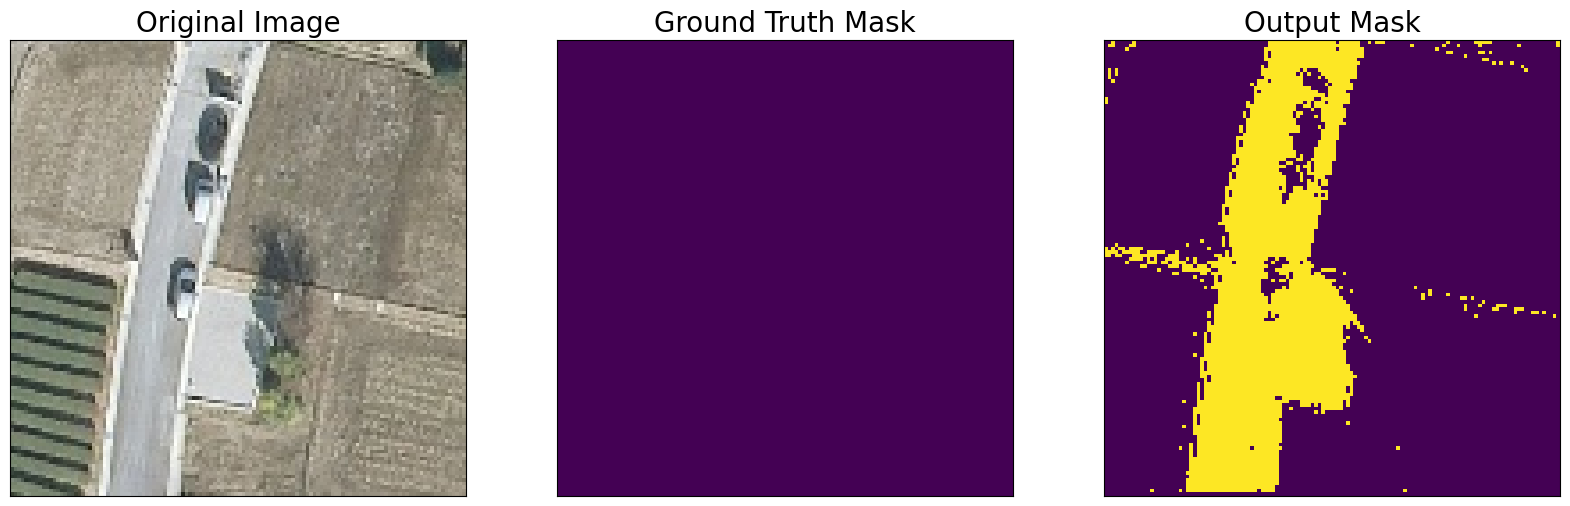

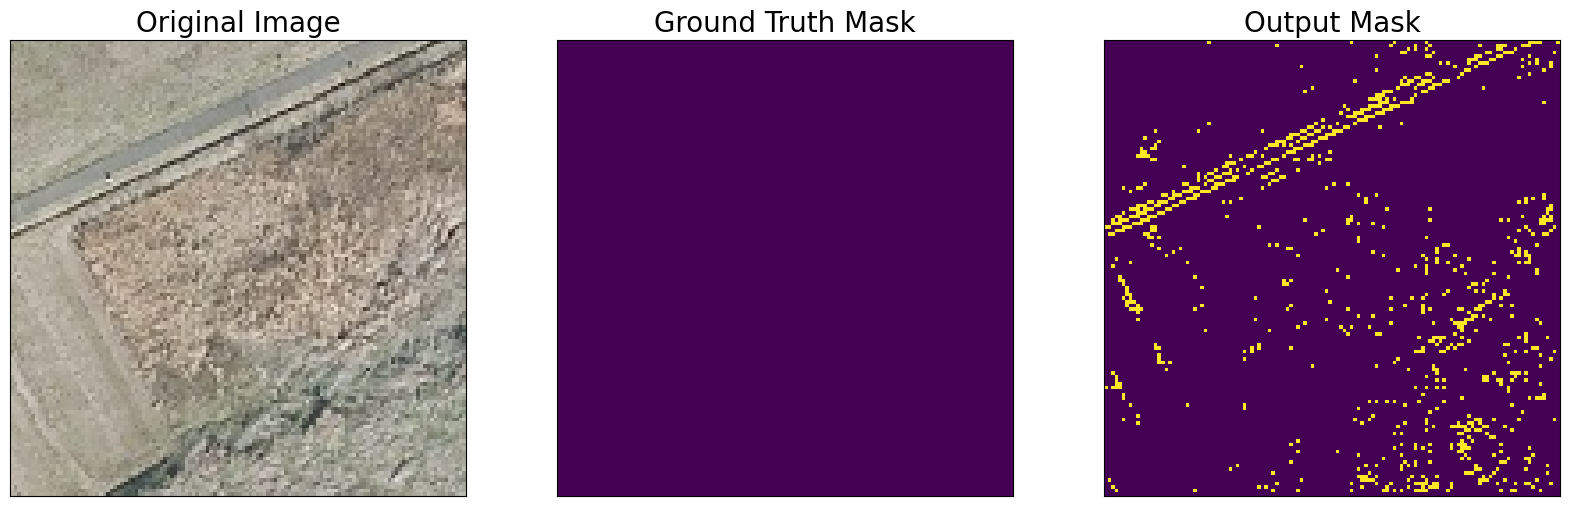

Epoch 2/30 (Train): 0batch [00:00, ?batch/s]

Epoch 1/30, Train Loss: 2.2297, Val Loss: 1.9956, Train IOU: 0.5302787772107133, Valid IOU: 0.5921554795483164


Epoch 2/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 2.077792193670616  iou_score: 0.584592704629681


Epoch 3/30 (Train): 59batch [01:41,  1.72s/batch]
Epoch 3/30 (Train): 59batch [01:46,  1.80s/batch]
Epoch 3/30 (Train): 59batch [01:47,  1.82s/batch]
Epoch 3/30 (Train): 59batch [01:48,  1.83s/batch]
Epoch 3/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 1.5952501773983432  iou_score: 0.6944826533929754

Epoch 3/30 (Train): 1batch [00:00,  6.24batch/s]

Epoch 3/30 (Train): 14batch [00:00, 25.61batch/s]





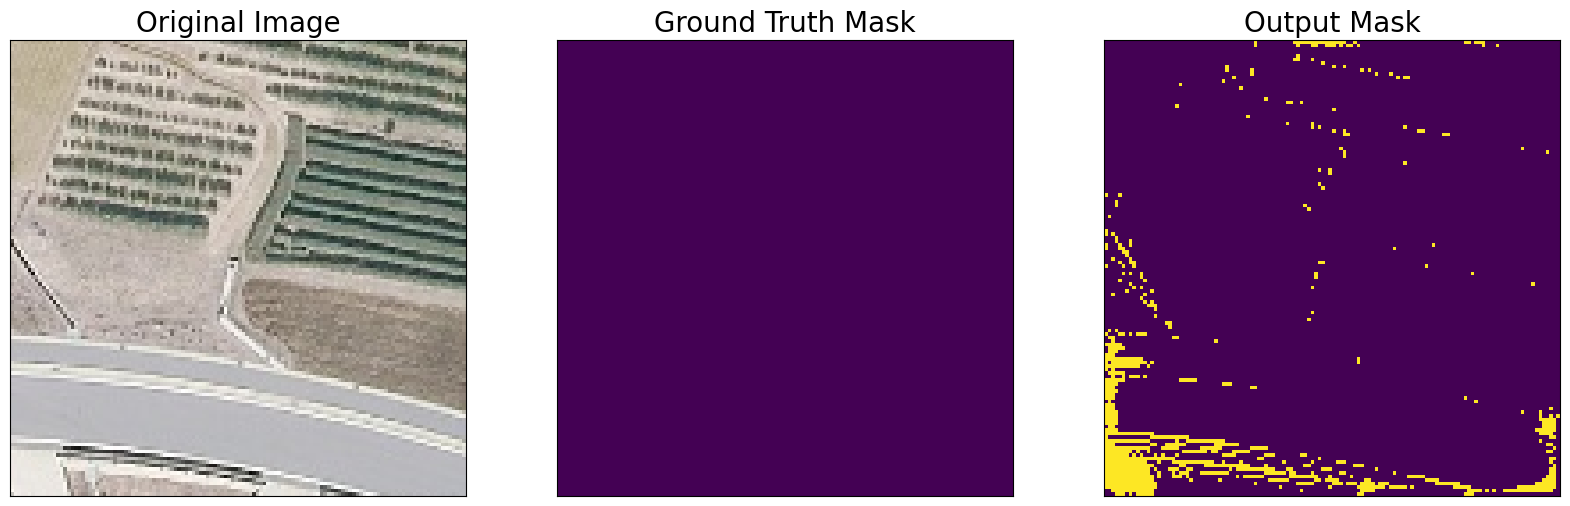

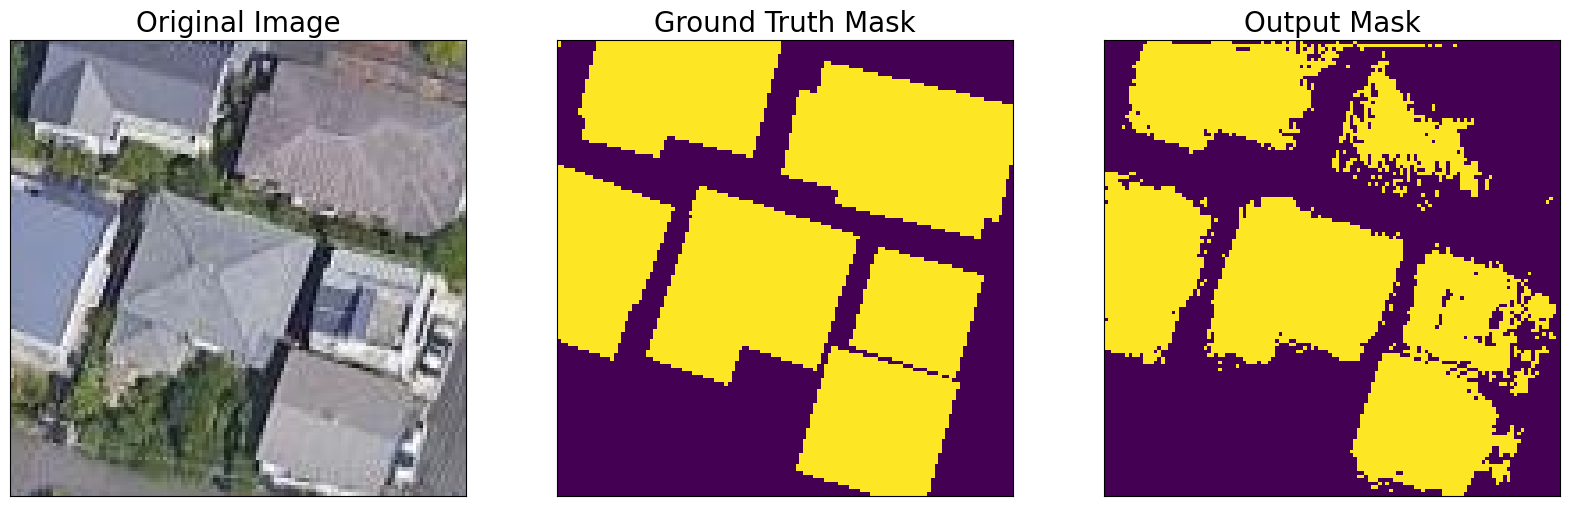

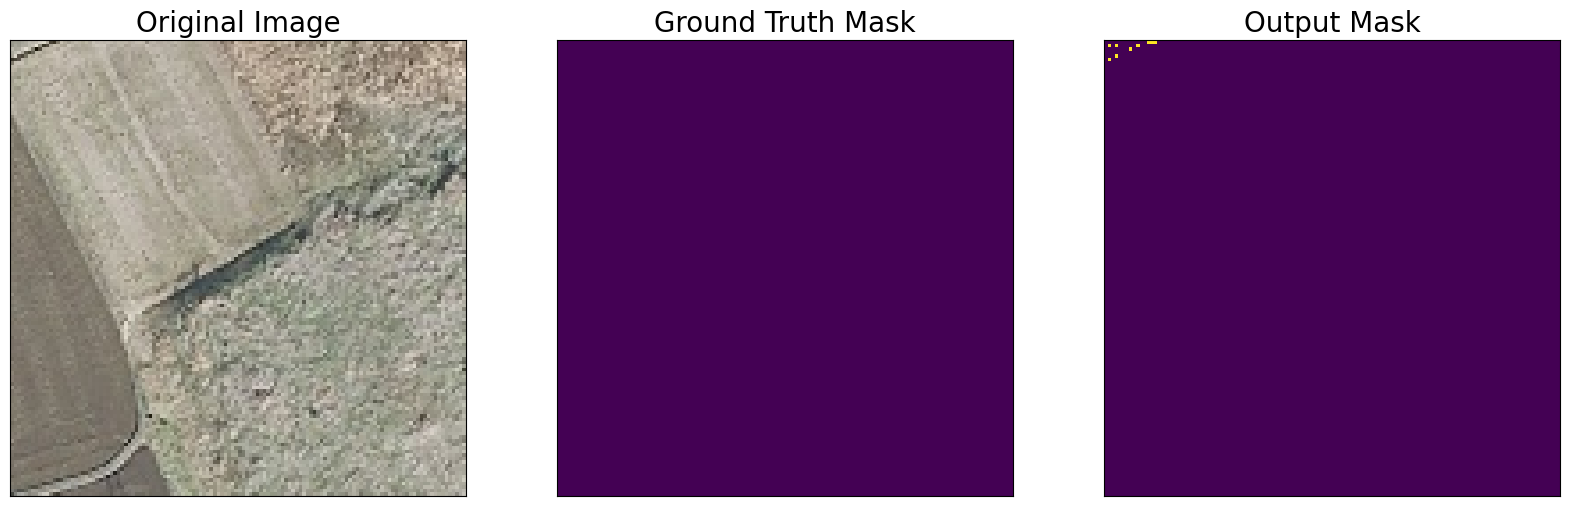

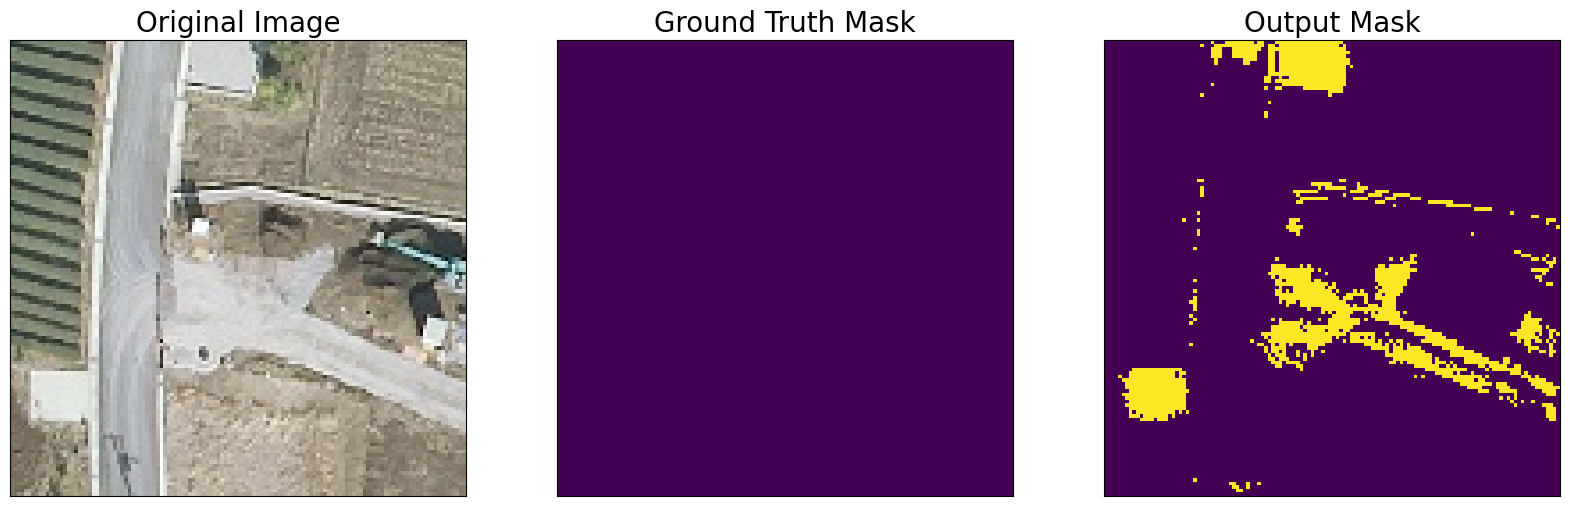

Epoch 4/30 (Train): 0batch [00:00, ?batch/s]

Epoch 3/30, Train Loss: 1.8787, Val Loss: 1.5807, Train IOU: 0.6303466872019239, Valid IOU: 0.7048541269399585


Epoch 4/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 1.7462382920148638  iou_score: 0.6831685081723662


Epoch 4/30 (Train): 59batch [01:54,  1.94s/batch]
Epoch 4/30 (Train): 59batch [01:48,  1.84s/batch]
Epoch 4/30 (Train): 59batch [01:55,  1.95s/batch]
Epoch 4/30 (Train): 59batch [01:55,  1.95s/batch]
Epoch 4/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 1.4781848315582504  iou_score: 0.7549656255092219

Epoch 4/30 (Train): 1batch [00:00,  3.39batch/s]

Epoch 4/30 (Train): 14batch [00:00, 24.31batch/s]



Epoch 5/30 (Train): 0batch [00:00, ?batch/s]

Epoch 4/30, Train Loss: 1.5485, Val Loss: 1.4373, Train IOU: 0.7349717591632, Valid IOU: 0.7676390683284658


Epoch 5/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 1.364902305755531  iou_score: 0.774017032030231


Epoch 5/30 (Train): 59batch [01:56,  1.97s/batch]
Epoch 5/30 (Train): 59batch [02:02,  2.07s/batch]
Epoch 5/30 (Train): 59batch [02:02,  2.07s/batch]
Epoch 5/30 (Train): 59batch [02:02,  2.07s/batch]
Epoch 5/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 1.1105487804120182  iou_score: 0.8278989421379257

Epoch 5/30 (Train): 1batch [00:00,  6.52batch/s]

Epoch 5/30 (Train): 14batch [00:00, 25.79batch/s]





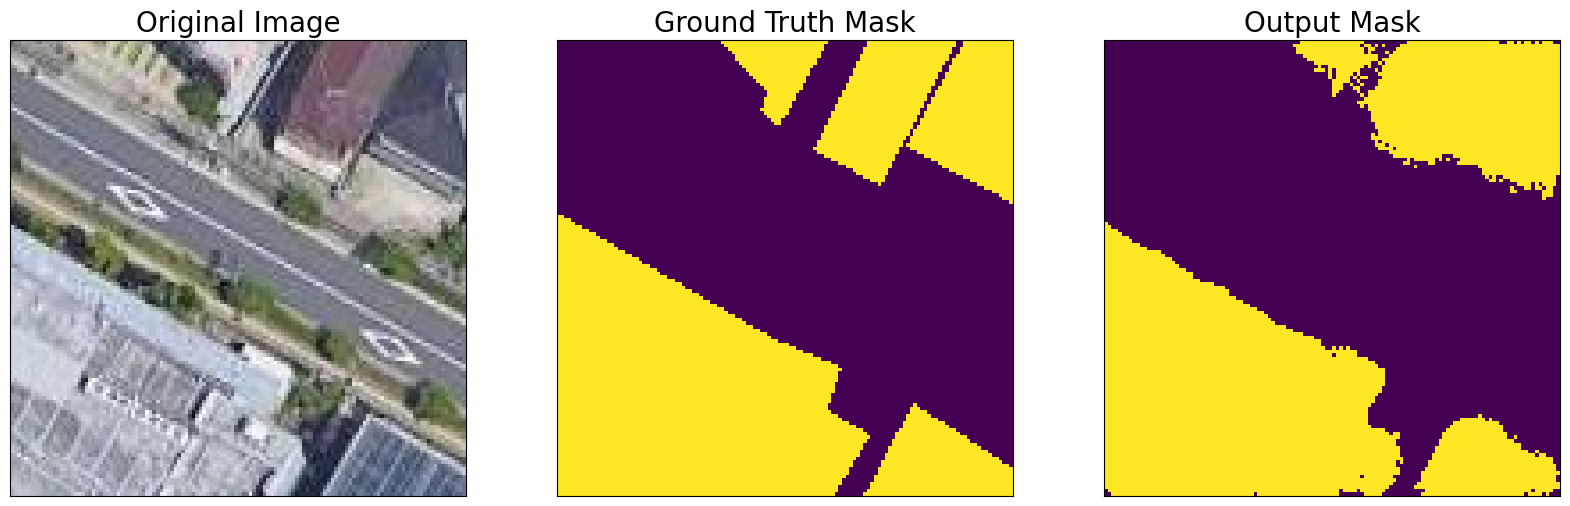

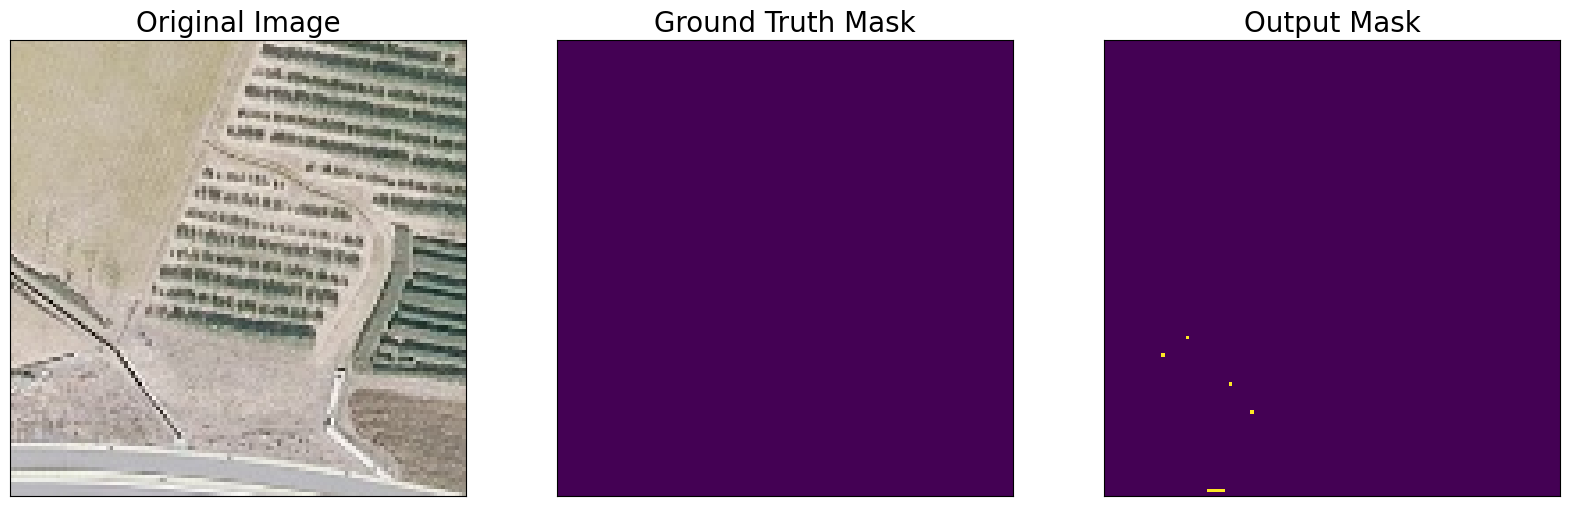

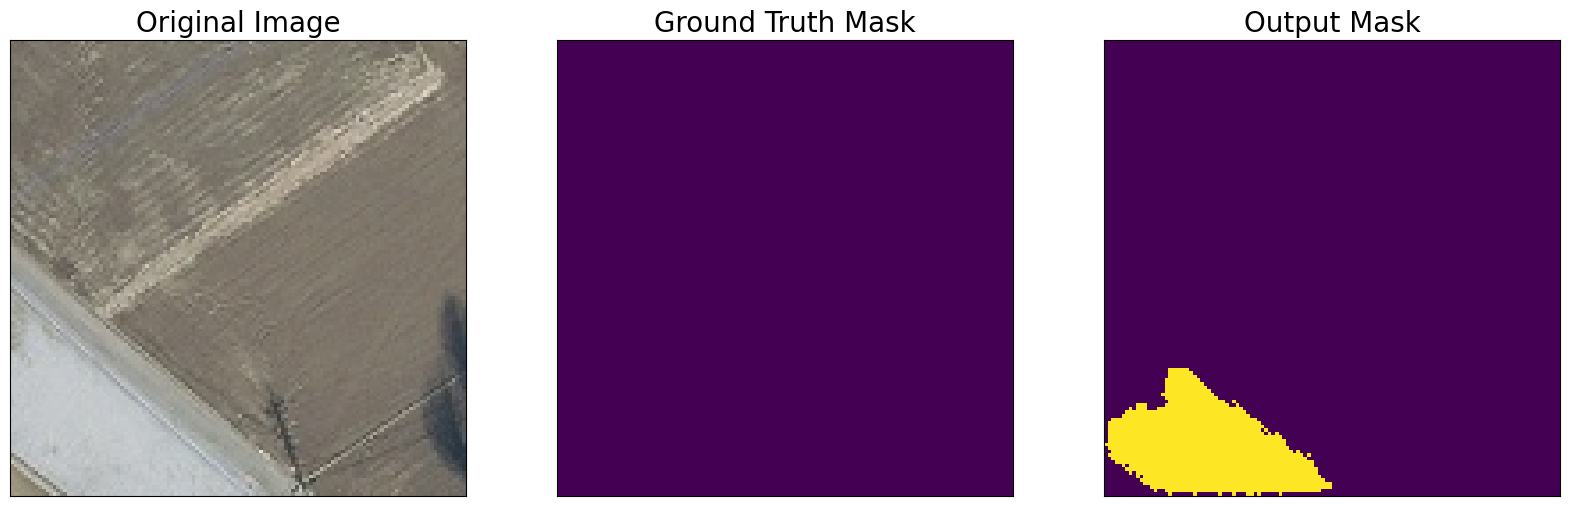

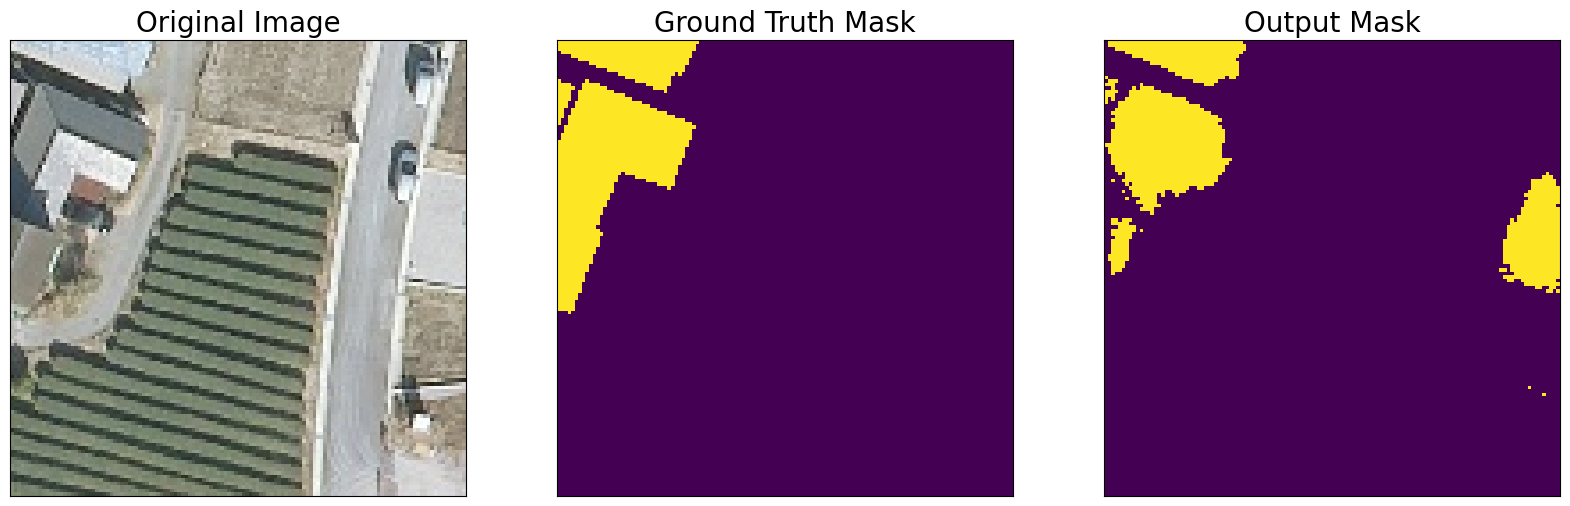

Epoch 6/30 (Train): 0batch [00:00, ?batch/s]

Epoch 5/30, Train Loss: 1.2999, Val Loss: 1.1317, Train IOU: 0.7847594907612016, Valid IOU: 0.8203788279452612


Epoch 6/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 1.1817403834665394  iou_score: 0.8081069657621103


Epoch 6/30 (Train): 59batch [01:46,  1.81s/batch]
Epoch 6/30 (Train): 59batch [01:52,  1.91s/batch]
Epoch 6/30 (Train): 59batch [01:53,  1.92s/batch]
Epoch 6/30 (Train): 59batch [01:51,  1.88s/batch]
Epoch 6/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 1.1088712653234056  iou_score: 0.8338164343568506

Epoch 6/30 (Train): 1batch [00:00,  3.93batch/s]

Epoch 6/30 (Train): 14batch [00:00, 18.44batch/s]



Epoch 7/30 (Train): 0batch [00:00, ?batch/s]

Epoch 6/30, Train Loss: 1.1744, Val Loss: 1.1369, Train IOU: 0.8096576732437852, Valid IOU: 0.8272546948742932


Epoch 7/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 1.129096096992249  iou_score: 0.8078955440192155


Epoch 7/30 (Train): 59batch [01:55,  1.96s/batch]
Epoch 7/30 (Train): 59batch [02:01,  2.07s/batch]
Epoch 7/30 (Train): 59batch [02:01,  2.06s/batch]
Epoch 7/30 (Train): 59batch [02:01,  2.06s/batch]
Epoch 7/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 1.0269239387405036  iou_score: 0.8428471559999084

Epoch 7/30 (Train): 1batch [00:00,  6.25batch/s]

Epoch 7/30 (Train): 14batch [00:00, 22.95batch/s]





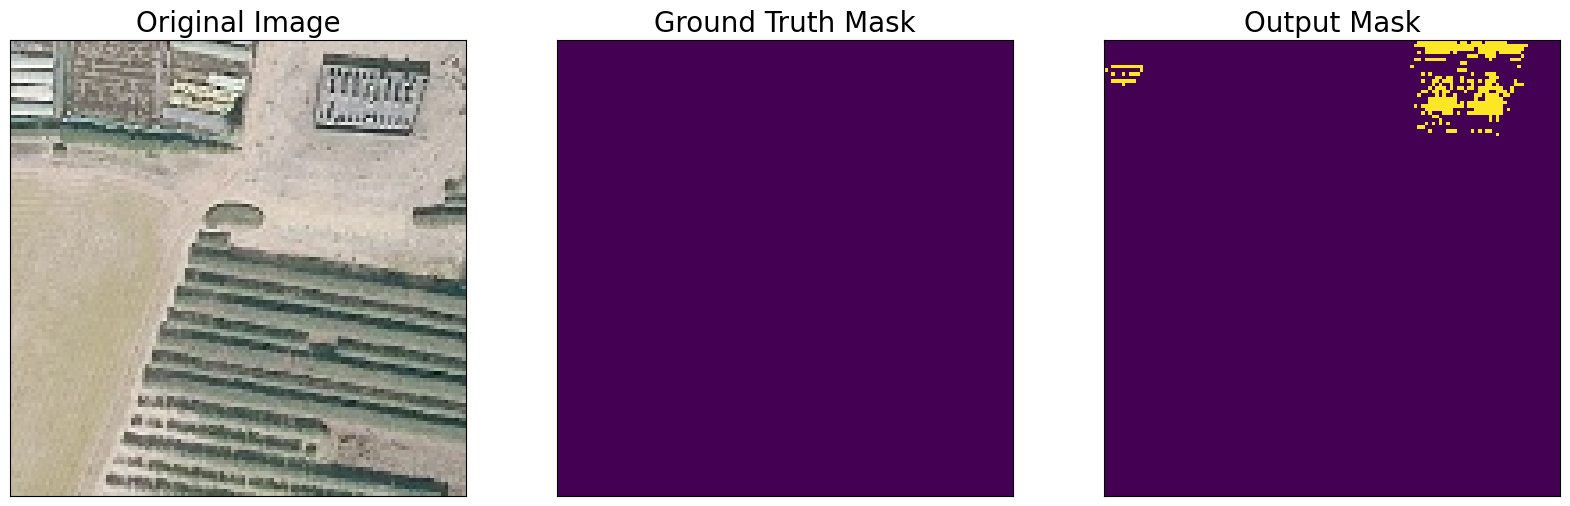

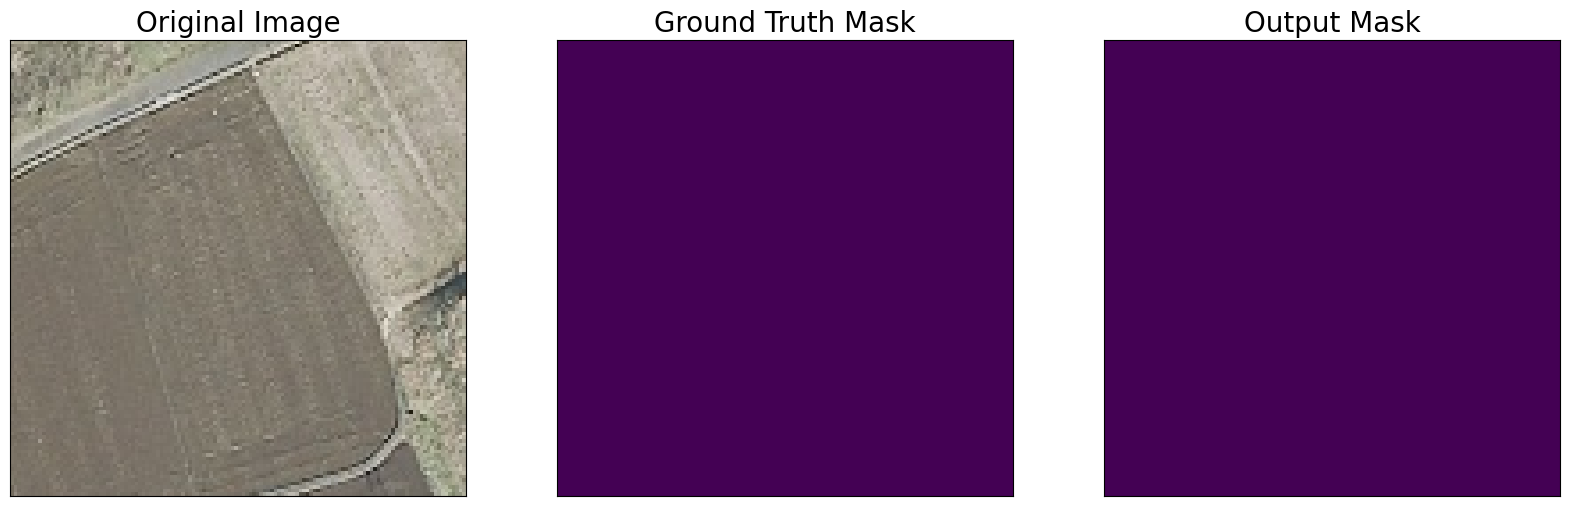

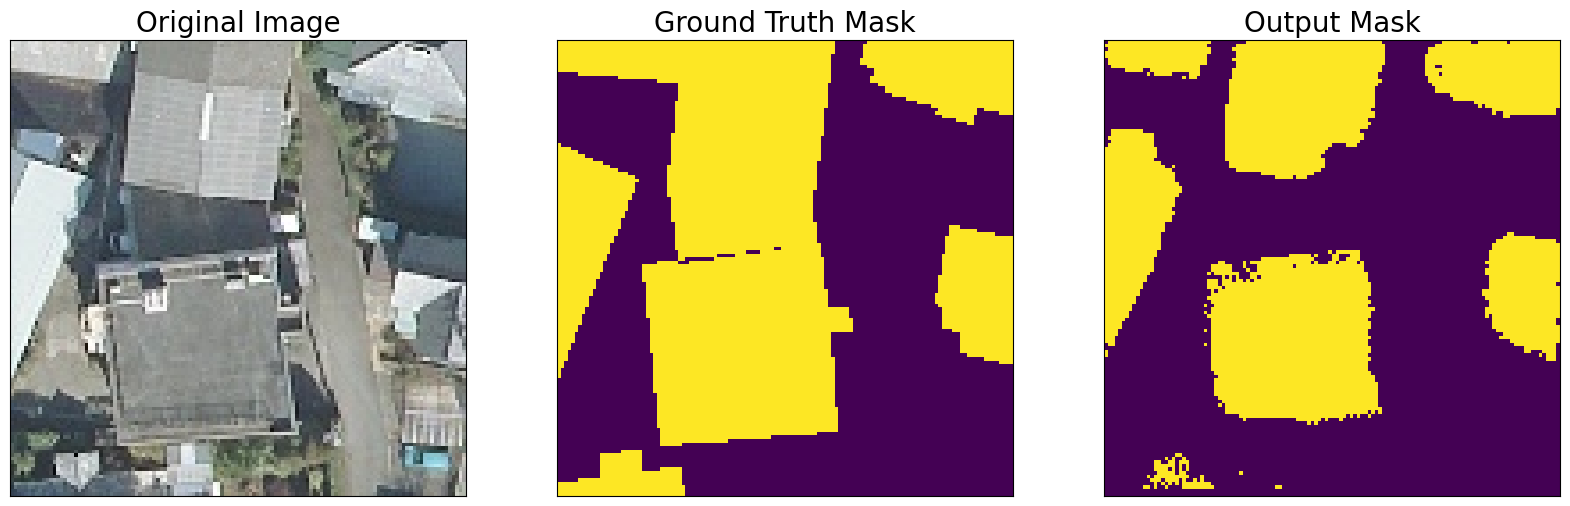

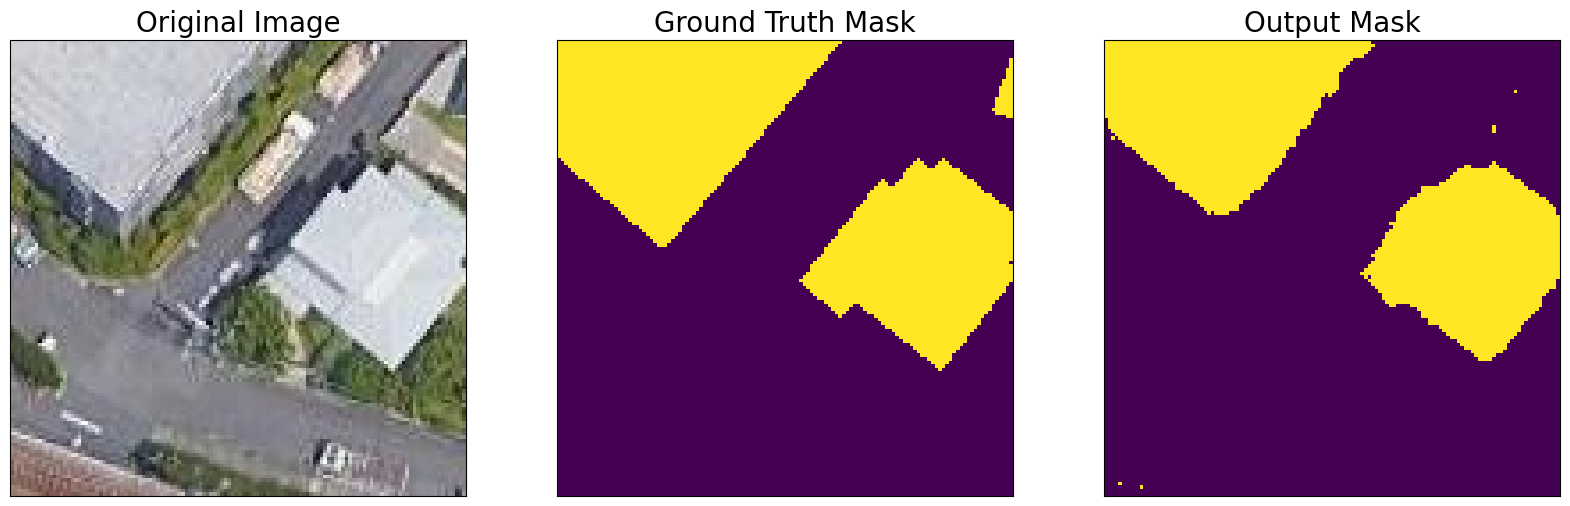

Epoch 7/30, Train Loss: 1.1201, Val Loss: 1.0876, Train IOU: 0.8170605159437362, Valid IOU: 0.8259164363163997


Epoch 8/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 1.0634887727054168  iou_score: 0.8309473834924725


Epoch 8/30 (Train): 59batch [01:45,  1.78s/batch]
Epoch 8/30 (Train): 59batch [01:46,  1.80s/batch]
Epoch 8/30 (Train): 59batch [01:46,  1.80s/batch]
Epoch 8/30 (Train): 59batch [01:45,  1.79s/batch]
Epoch 8/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9660470514193937  iou_score: 0.8518681266952788

Epoch 8/30 (Train): 1batch [00:00,  1.19batch/s]

Epoch 8/30 (Train): 14batch [00:01,  9.65batch/s]
Epoch 8/30 (Train): 14batch [00:00, 24.83batch/s]




Epoch 8/30, Train Loss: 1.0895, Val Loss: 1.0678, Train IOU: 0.8218871639059073, Valid IOU: 0.8268512637737808


Epoch 9/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 1.110601986894608  iou_score: 0.8121044009088694


Epoch 9/30 (Train): 59batch [01:46,  1.80s/batch]
Epoch 9/30 (Train): 59batch [01:46,  1.80s/batch]
Epoch 9/30 (Train): 59batch [01:45,  1.79s/batch]
Epoch 9/30 (Train): 59batch [01:45,  1.79s/batch]
Epoch 9/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.990765969757763  iou_score: 0.850580389709332

Epoch 9/30 (Train): 1batch [00:00,  1.01batch/s]

Epoch 9/30 (Train): 14batch [00:00, 24.96batch/s]





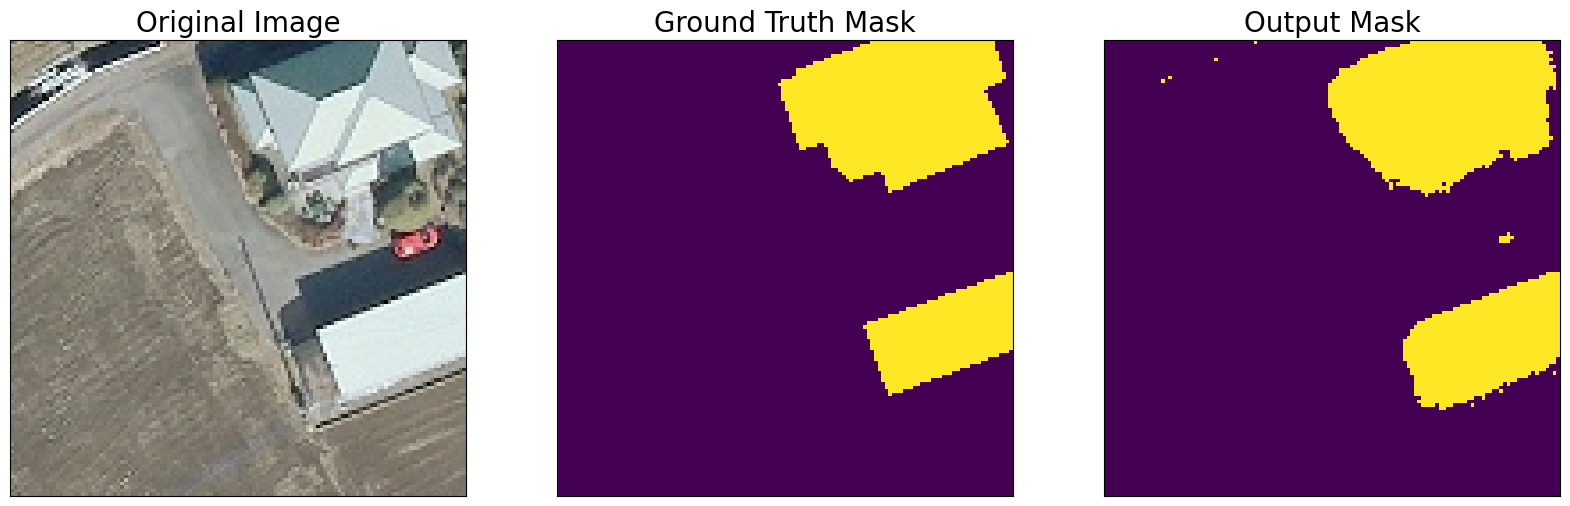

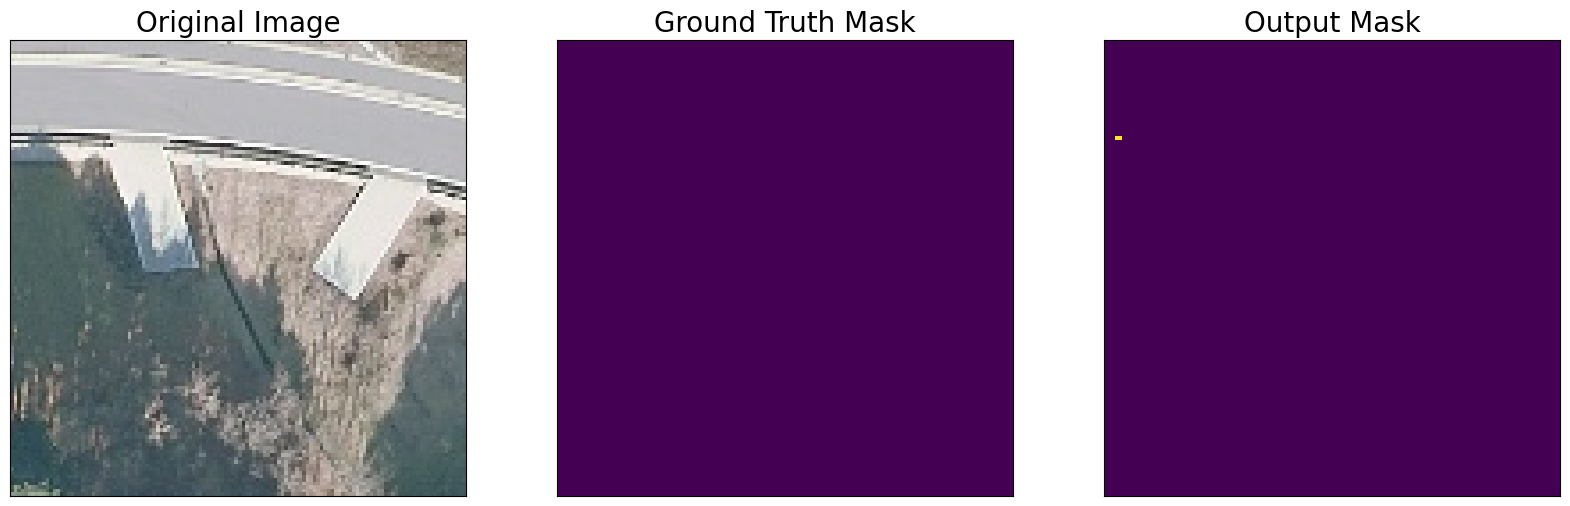

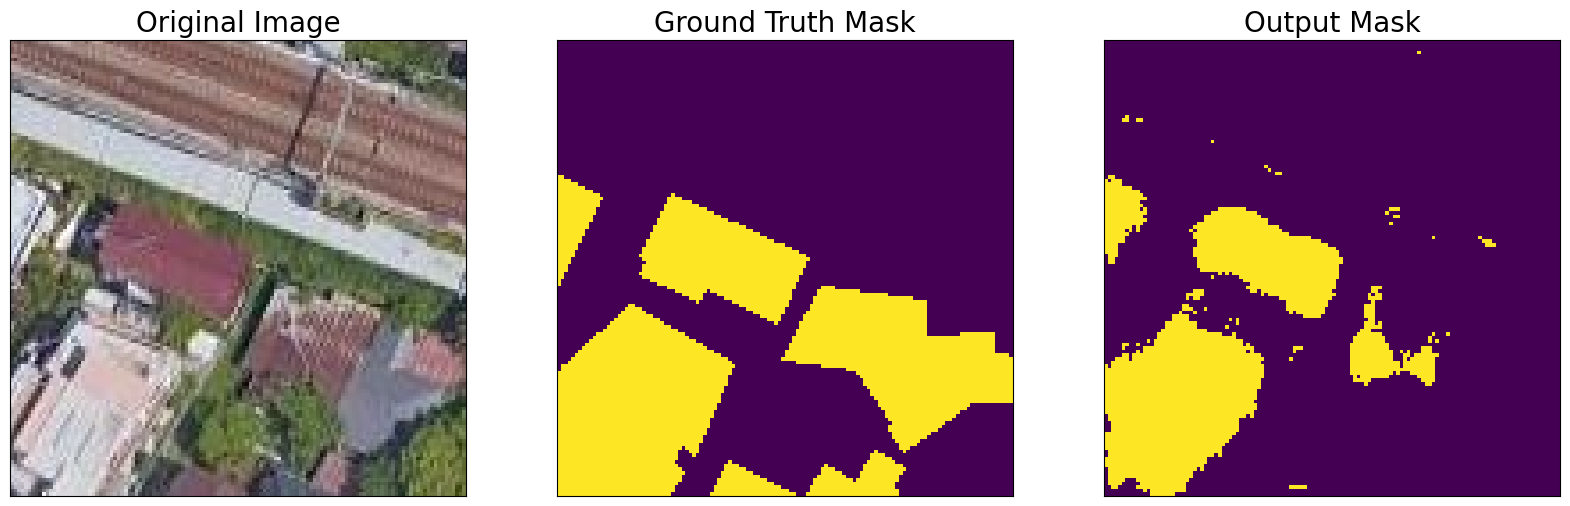

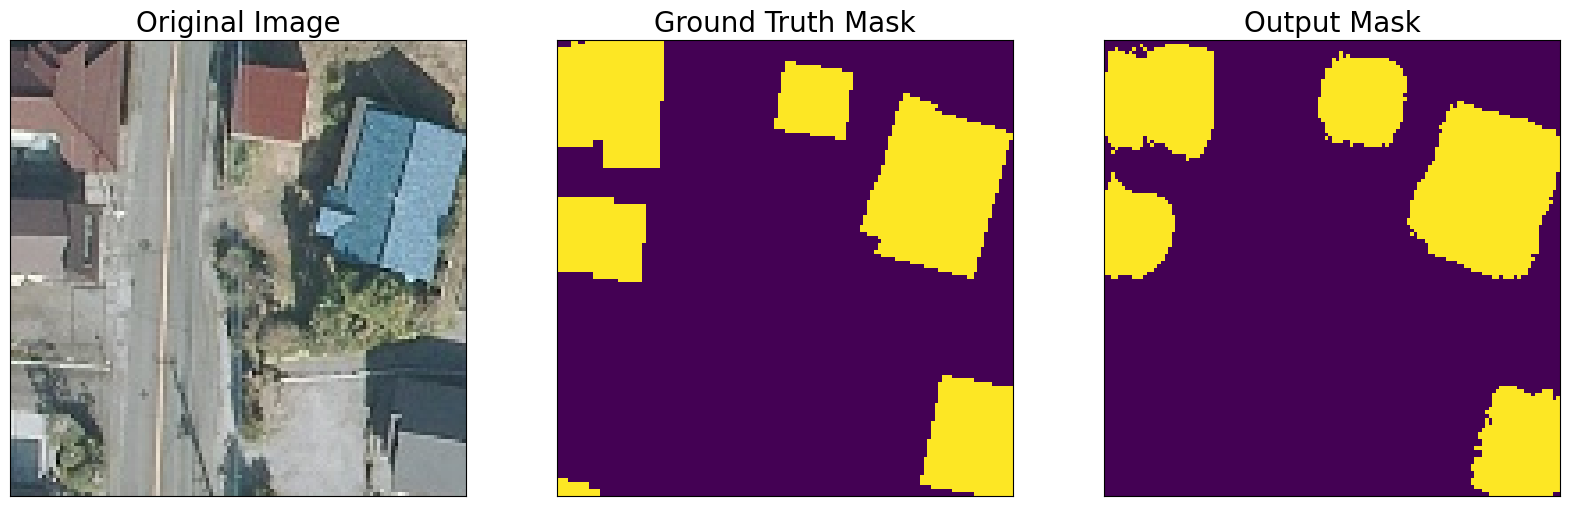

Epoch 10/30 (Train): 0batch [00:00, ?batch/s]

Epoch 9/30, Train Loss: 1.0528, Val Loss: 1.0088, Train IOU: 0.8272369405700273, Valid IOU: 0.842013295401115


Epoch 10/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9929766642099378  iou_score: 0.8391830585314954


Epoch 10/30 (Train): 59batch [01:45,  1.78s/batch]
Epoch 10/30 (Train): 59batch [01:43,  1.76s/batch]
Epoch 10/30 (Train): 59batch [01:37,  1.66s/batch]
Epoch 10/30 (Train): 59batch [01:44,  1.77s/batch]
Epoch 10/30 (Train): 1batch [00:00,  5.89batch/s]

Train_Batch: 0, loss: 0.9167708083875539  iou_score: 0.8442506930164653

Epoch 10/30 (Train): 1batch [00:00,  6.07batch/s]

Epoch 10/30 (Train): 14batch [00:00, 25.82batch/s]



Epoch 11/30 (Train): 0batch [00:00, ?batch/s]

Epoch 10/30, Train Loss: 1.0162, Val Loss: 0.9064, Train IOU: 0.8323118272940141, Valid IOU: 0.8518229458439585


Epoch 11/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9731273092393715  iou_score: 0.8281485516765883


Epoch 11/30 (Train): 59batch [01:43,  1.75s/batch]
Epoch 11/30 (Train): 59batch [01:49,  1.86s/batch]
Epoch 11/30 (Train): 59batch [01:49,  1.85s/batch]
Epoch 11/30 (Train): 59batch [01:48,  1.84s/batch]
Epoch 11/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.8588810118457221  iou_score: 0.8679099771933192

Epoch 11/30 (Train): 1batch [00:00,  1.03batch/s]

Epoch 11/30 (Train): 14batch [00:00, 25.23batch/s]





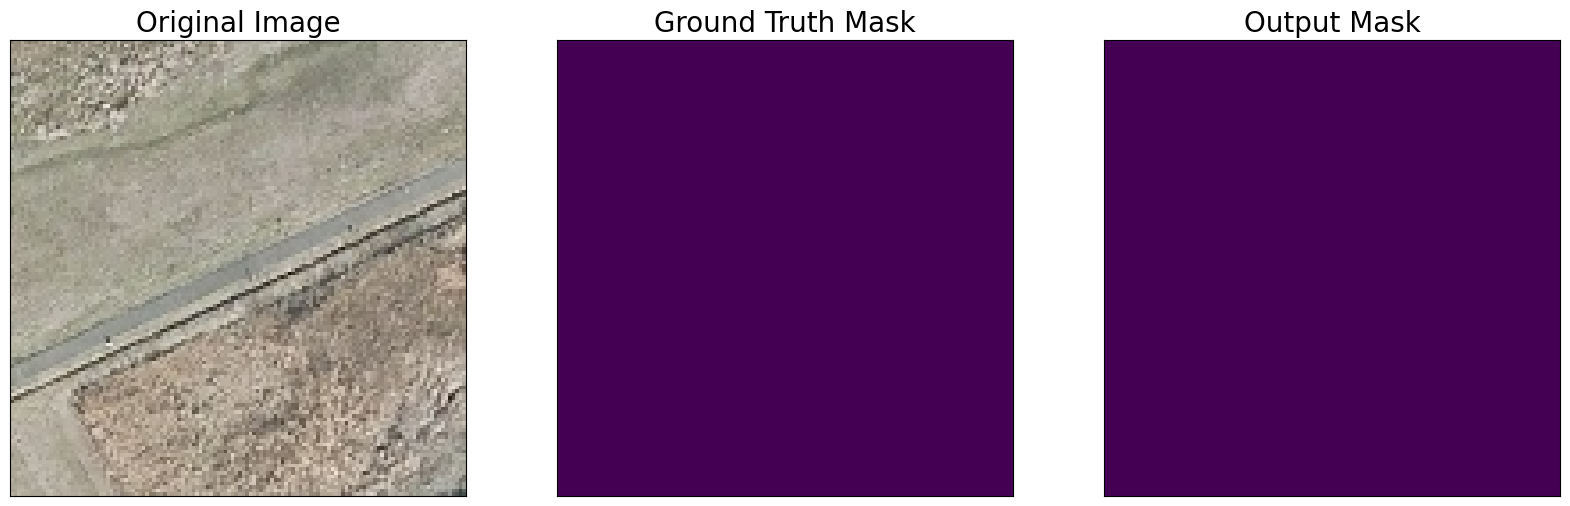

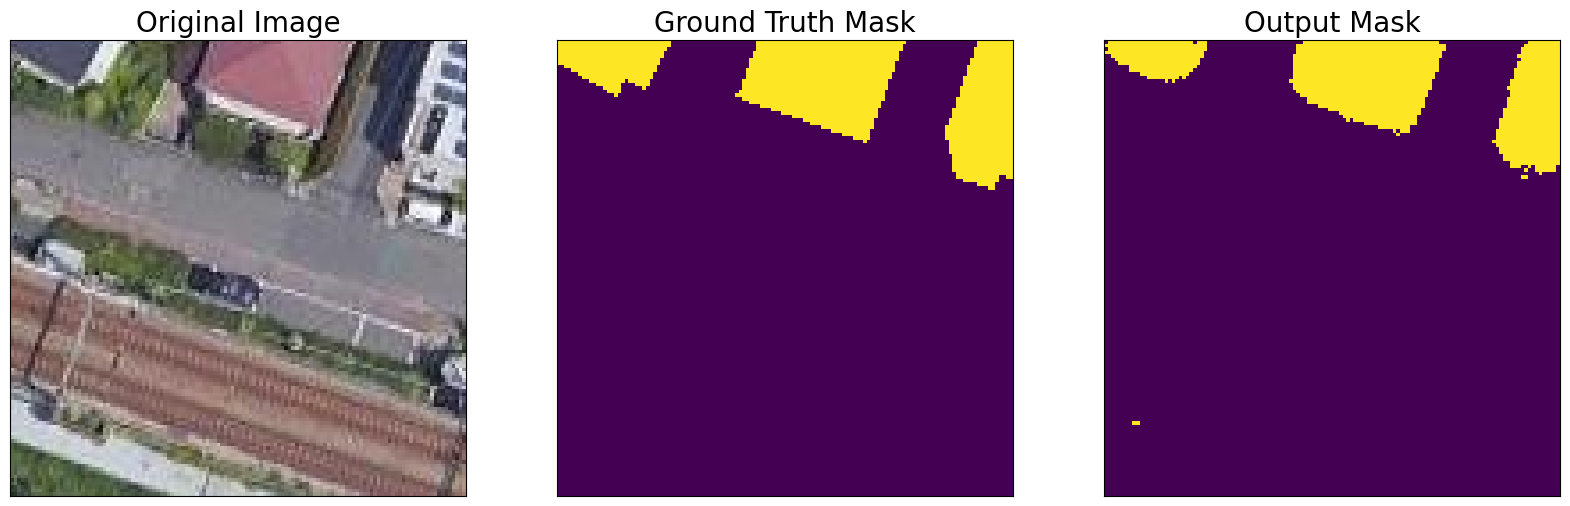

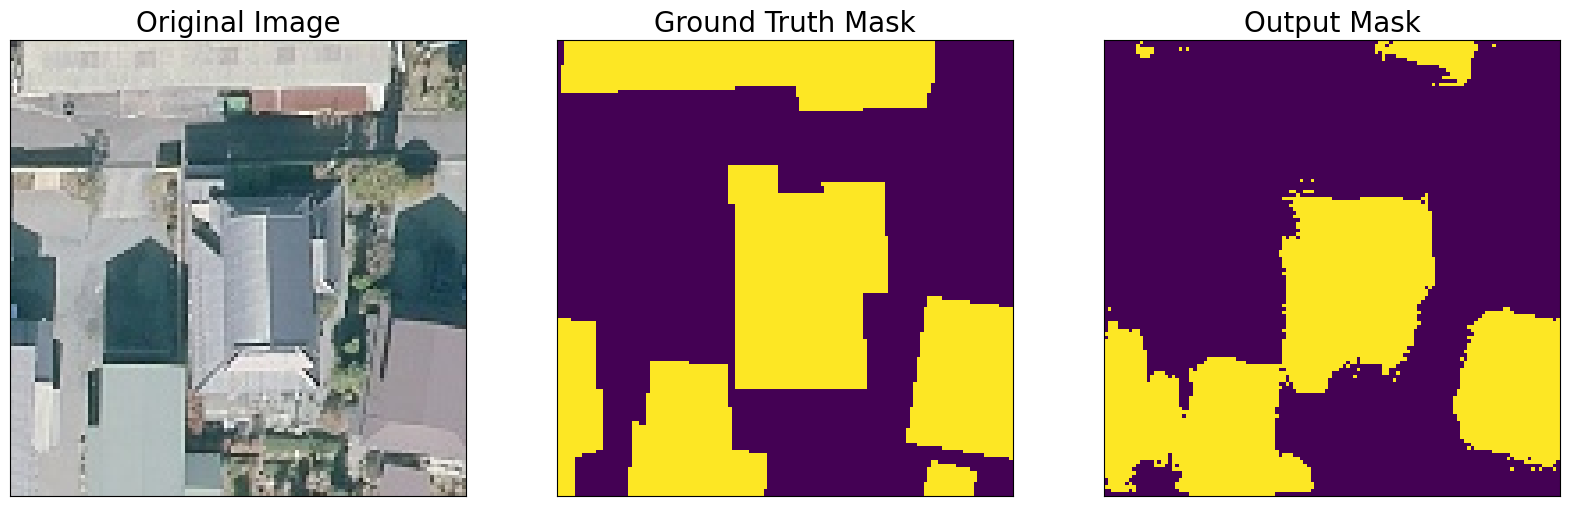

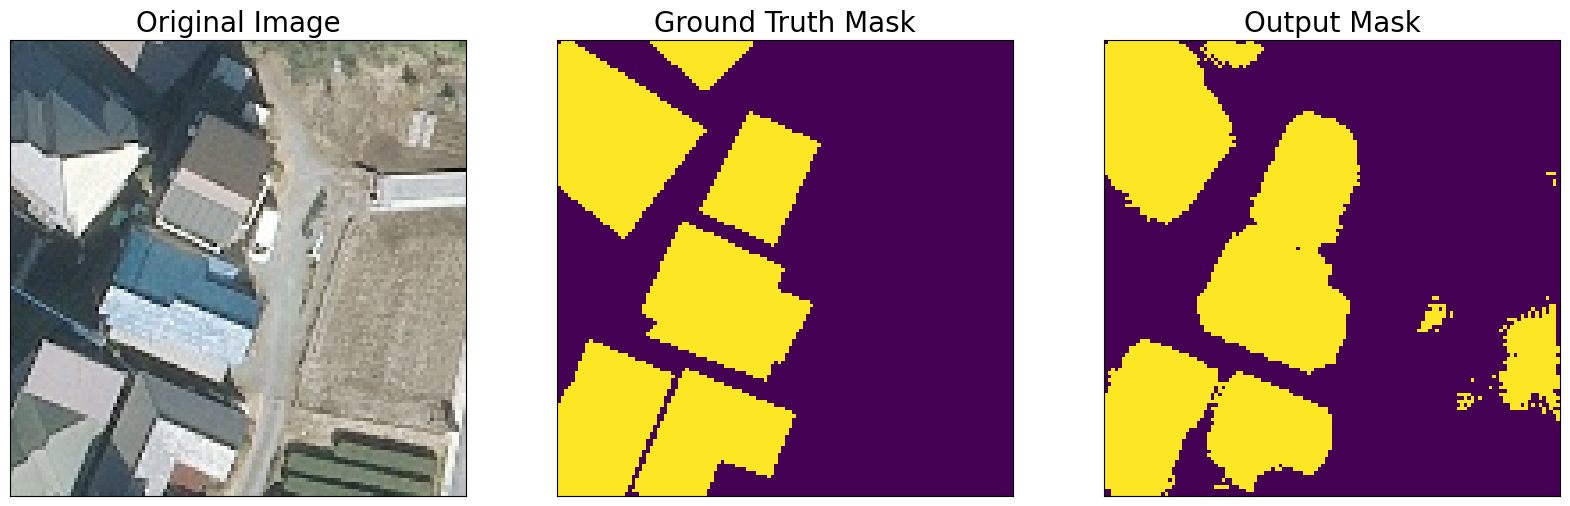

Epoch 11/30, Train Loss: 0.9960, Val Loss: 0.9377, Train IOU: 0.8370848711546434, Valid IOU: 0.8456021764974188


Epoch 12/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9191770769772374  iou_score: 0.8460739954728804


Epoch 12/30 (Train): 59batch [01:44,  1.77s/batch]
Epoch 12/30 (Train): 59batch [01:44,  1.77s/batch]
Epoch 12/30 (Train): 59batch [01:44,  1.78s/batch]
Epoch 12/30 (Train): 59batch [01:41,  1.73s/batch]
Epoch 12/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.871120440858508  iou_score: 0.8697713512226298

Epoch 12/30 (Train): 1batch [00:00,  5.37batch/s]

Epoch 12/30 (Train): 14batch [00:00, 25.46batch/s]

Epoch 12/30 (Train): 14batch [00:00, 23.88batch/s]

Epoch 13/30 (Train): 0batch [00:00, ?batch/s]

Epoch 12/30, Train Loss: 0.9642, Val Loss: 0.9505, Train IOU: 0.8451081331610408, Valid IOU: 0.851920373987538


Epoch 13/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9706934960331843  iou_score: 0.8395970809729838


Epoch 13/30 (Train): 59batch [01:40,  1.70s/batch]
Epoch 13/30 (Train): 59batch [01:47,  1.82s/batch]
Epoch 13/30 (Train): 0batch [00:00, ?batch/s]atch]
Epoch 13/30 (Train): 59batch [01:46,  1.81s/batch]
Epoch 13/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9039539749948116  iou_score: 0.8524002407338851


Epoch 13/30 (Train): 14batch [00:00, 24.65batch/s]
Epoch 13/30 (Train): 14batch [00:00, 22.69batch/s]




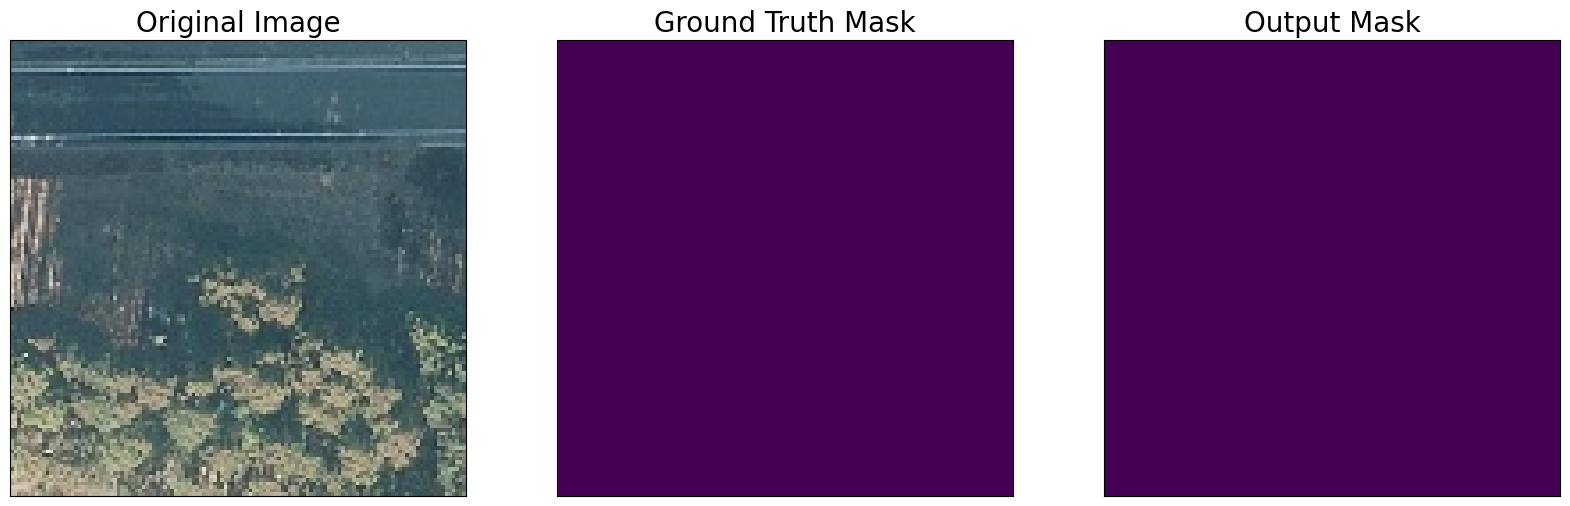

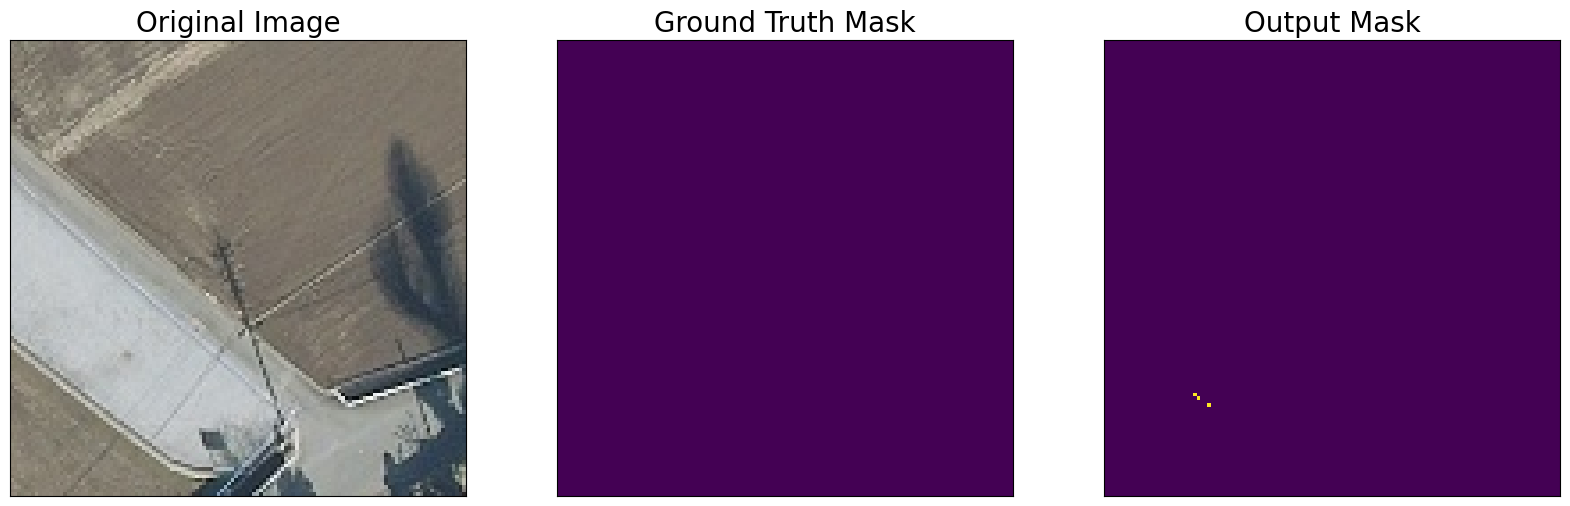

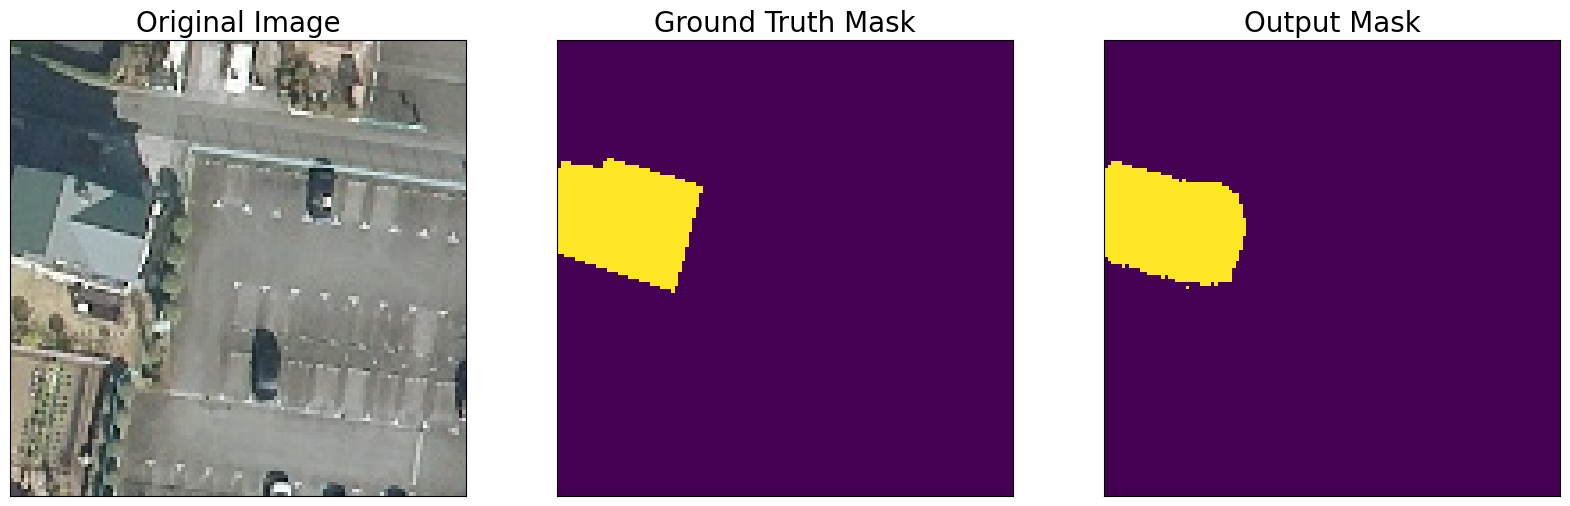

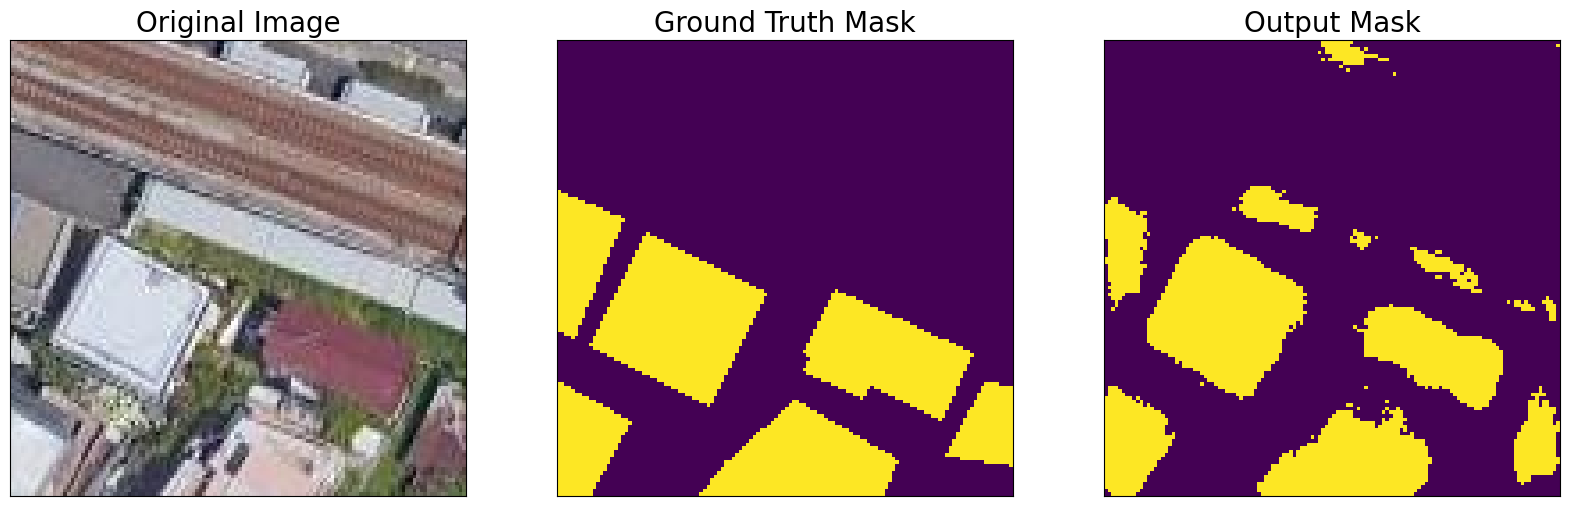

Epoch 14/30 (Train): 0batch [00:00, ?batch/s]

Epoch 13/30, Train Loss: 0.9485, Val Loss: 0.9026, Train IOU: 0.8510300609845832, Valid IOU: 0.8586674447171665


Epoch 14/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9042915143900516  iou_score: 0.8595724671680647


Epoch 14/30 (Train): 59batch [04:20,  4.41s/batch]
Epoch 14/30 (Train): 59batch [04:26,  4.52s/batch]
Epoch 14/30 (Train): 59batch [04:27,  4.53s/batch]
Epoch 14/30 (Train): 59batch [04:26,  4.51s/batch]
Epoch 14/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9243405397366931  iou_score: 0.8440114751827072

Epoch 14/30 (Train): 1batch [00:00,  4.37batch/s]

Epoch 14/30 (Train): 14batch [00:00, 18.89batch/s]


Epoch 14/30 (Train): 14batch [00:00, 23.00batch/s]


Epoch 14/30, Train Loss: 0.9523, Val Loss: 0.9006, Train IOU: 0.8484842583806486, Valid IOU: 0.857758205127249


Epoch 15/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 1.0142471666609514  iou_score: 0.8167693998934421


Epoch 15/30 (Train): 59batch [01:47,  1.82s/batch]
Epoch 15/30 (Train): 59batch [01:47,  1.82s/batch]
Epoch 15/30 (Train): 59batch [01:46,  1.80s/batch]
Epoch 15/30 (Train): 59batch [01:47,  1.81s/batch]
Epoch 15/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9159990739992758  iou_score: 0.8512321679571055

Epoch 15/30 (Train): 1batch [00:00,  5.47batch/s]

Epoch 15/30 (Train): 14batch [00:00, 22.62batch/s]





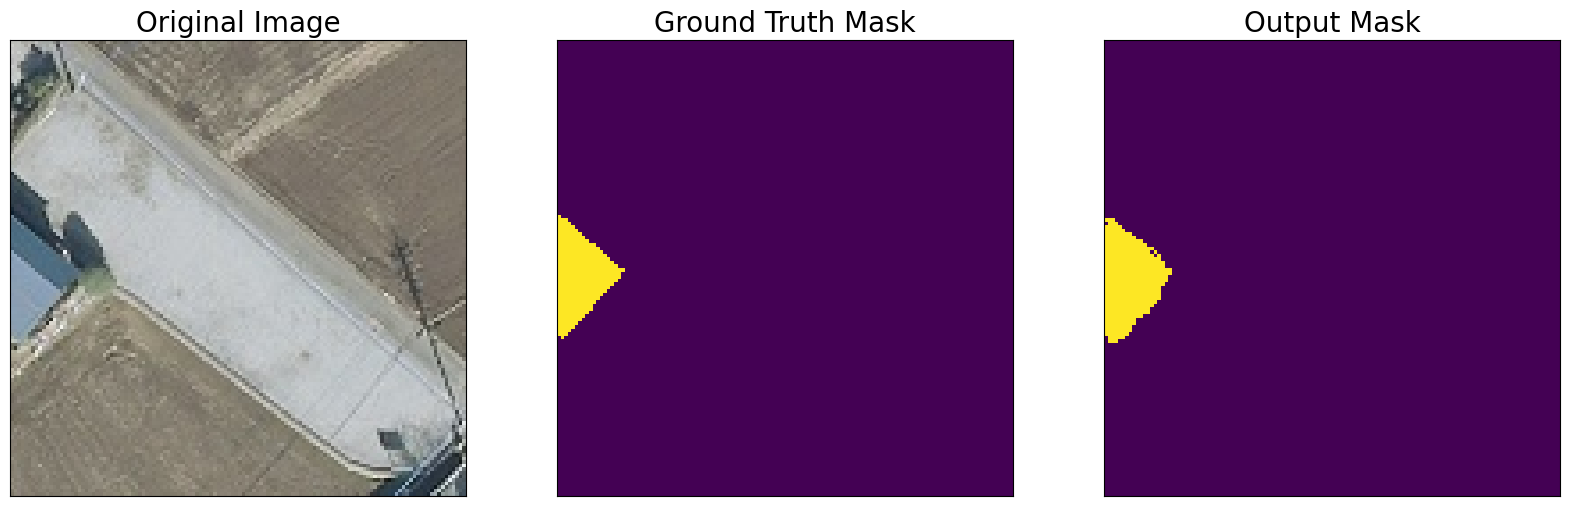

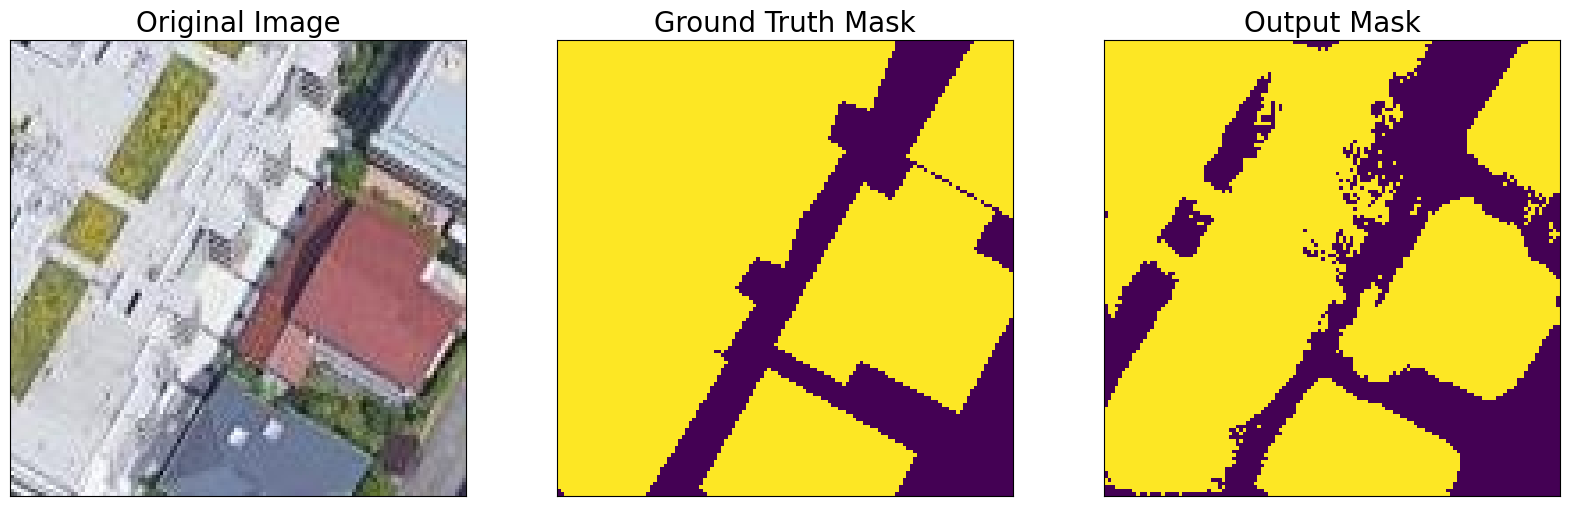

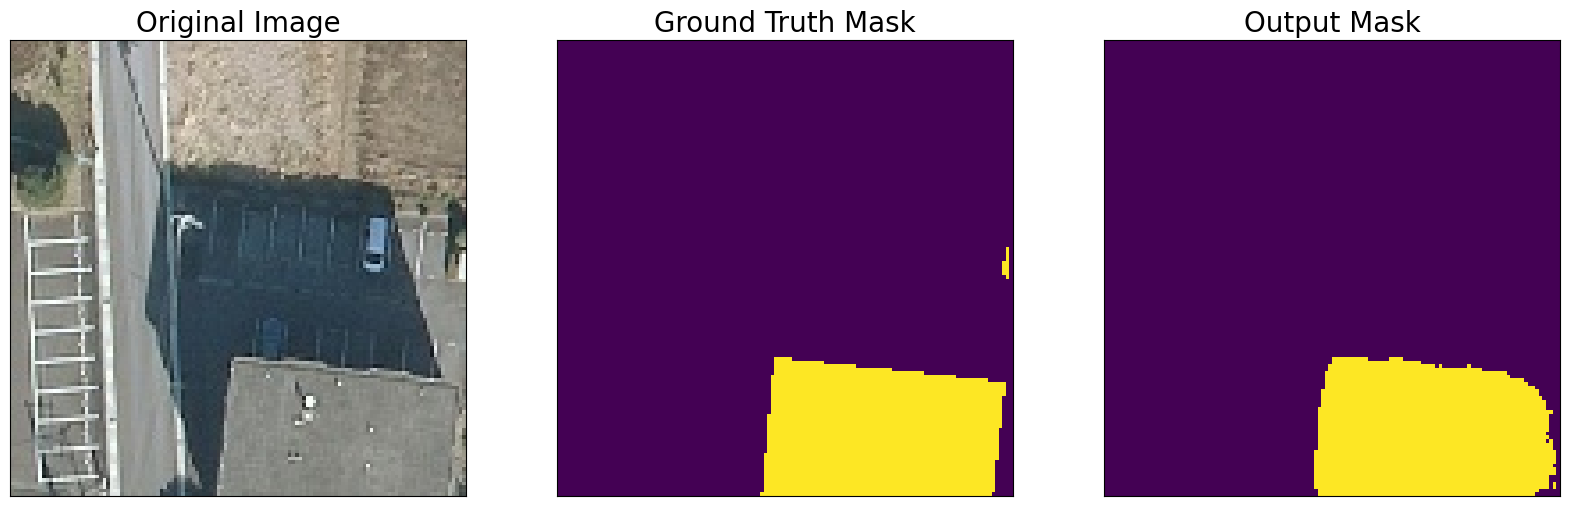

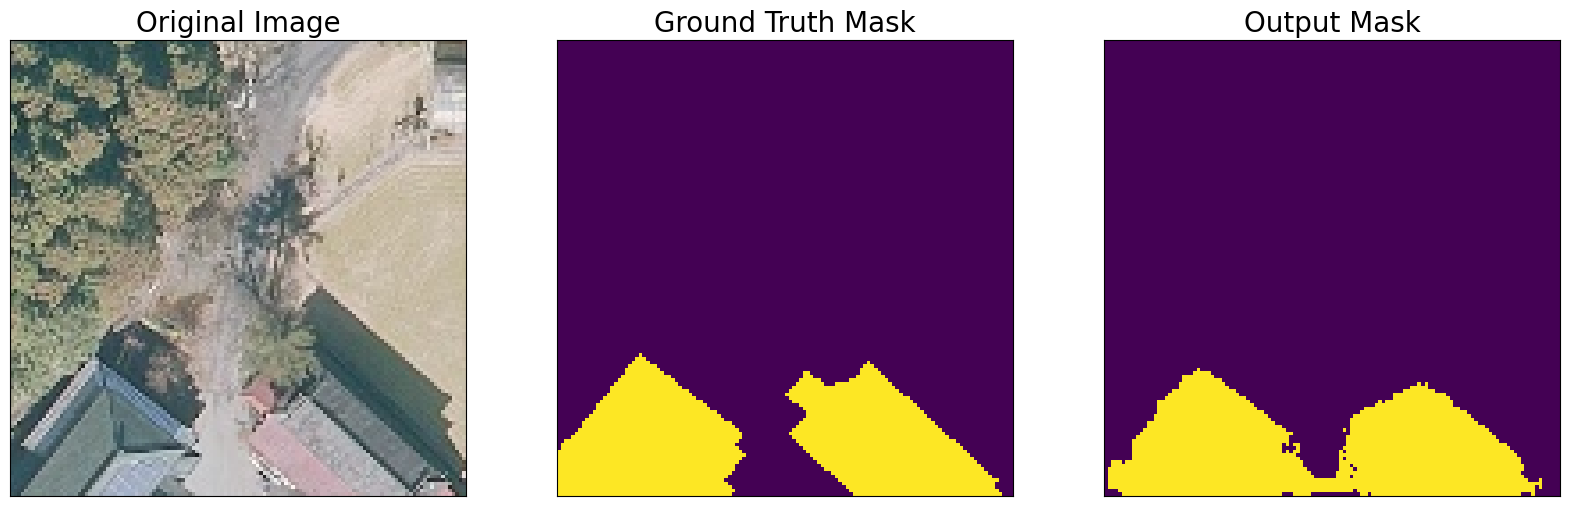

Epoch 15/30, Train Loss: 0.9558, Val Loss: 0.9124, Train IOU: 0.8456641791301619, Valid IOU: 0.8541767598627418


Epoch 16/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.8849343932314876  iou_score: 0.863000138921916


Epoch 16/30 (Train): 59batch [01:53,  1.93s/batch]
Epoch 16/30 (Train): 59batch [01:53,  1.93s/batch]
Epoch 16/30 (Train): 59batch [01:53,  1.93s/batch]
Epoch 16/30 (Train): 59batch [01:52,  1.90s/batch]
Epoch 16/30 (Train): 1batch [00:00,  4.91batch/s]

Train_Batch: 0, loss: 0.9452621715904115  iou_score: 0.8318335857453456


Epoch 16/30 (Train): 14batch [00:00, 19.26batch/s]
Epoch 16/30 (Train): 14batch [00:00, 22.64batch/s]




Epoch 16/30, Train Loss: 0.9445, Val Loss: 0.9201, Train IOU: 0.8491852030126378, Valid IOU: 0.8531951938676915


Epoch 17/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9722767723051345  iou_score: 0.8313552925571344


Epoch 17/30 (Train): 59batch [01:47,  1.83s/batch]
Epoch 17/30 (Train): 59batch [01:48,  1.84s/batch]
Epoch 17/30 (Train): 59batch [01:48,  1.84s/batch]
Epoch 17/30 (Train): 59batch [01:47,  1.82s/batch]
Epoch 17/30 (Train): 1batch [00:00,  1.62batch/s]

Train_Batch: 0, loss: 0.844057930622762  iou_score: 0.8712610911167694


Epoch 17/30 (Train): 14batch [00:00, 25.33batch/s]





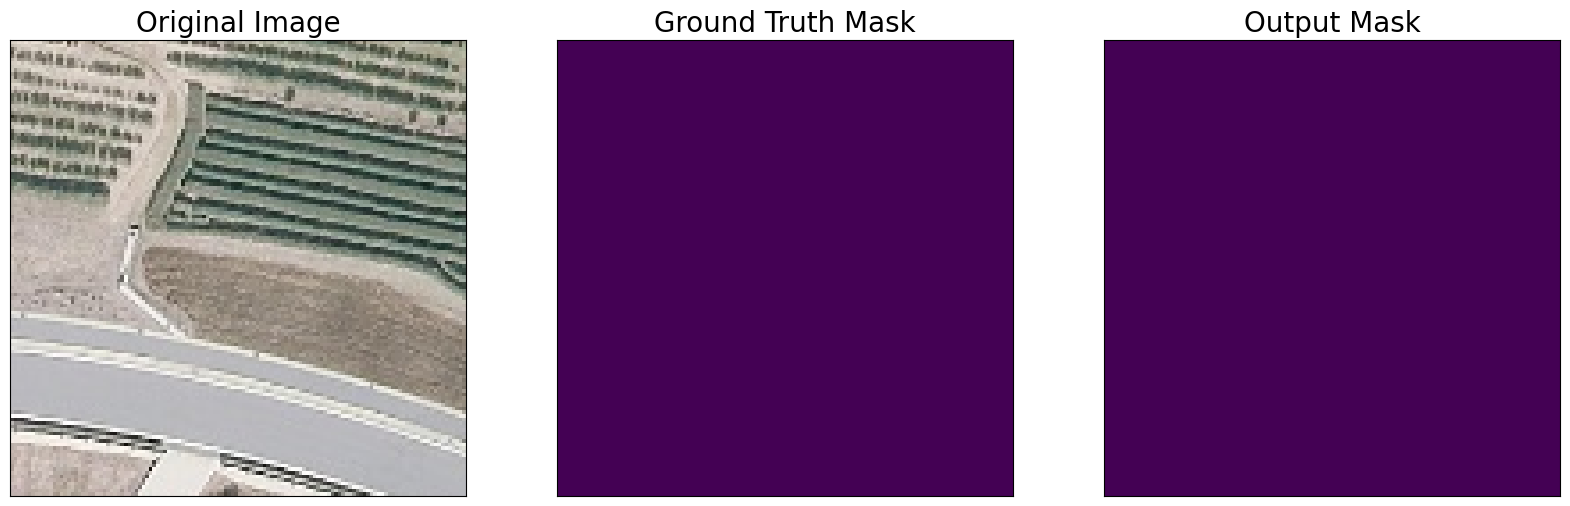

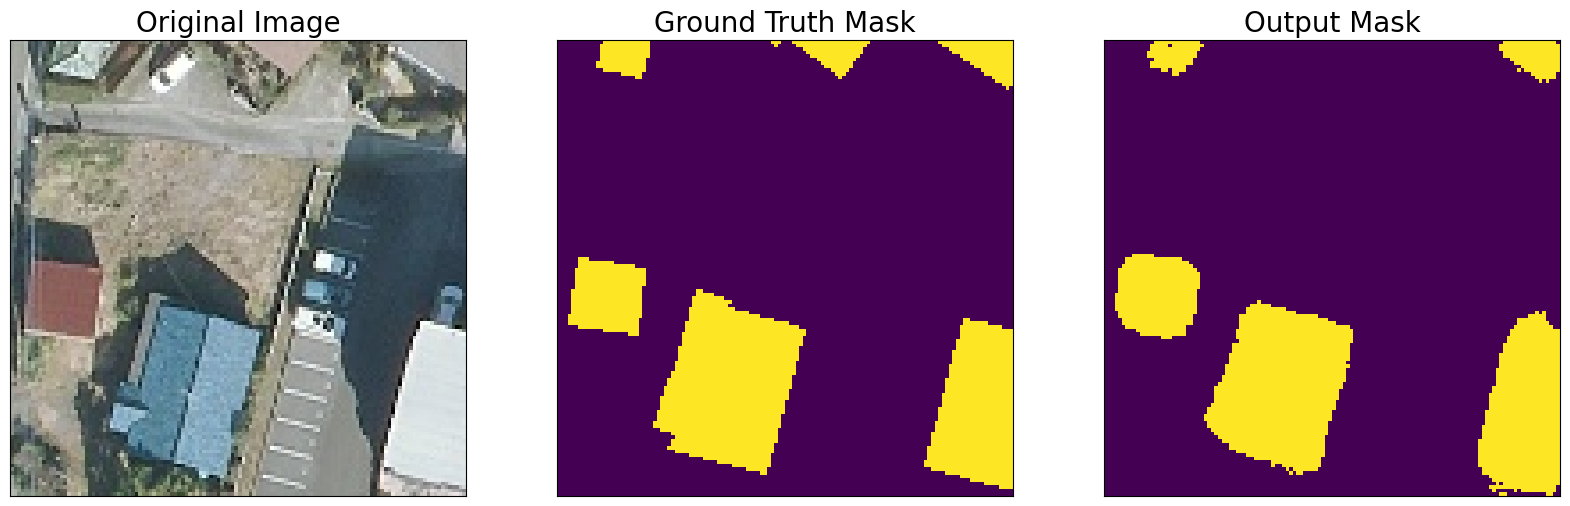

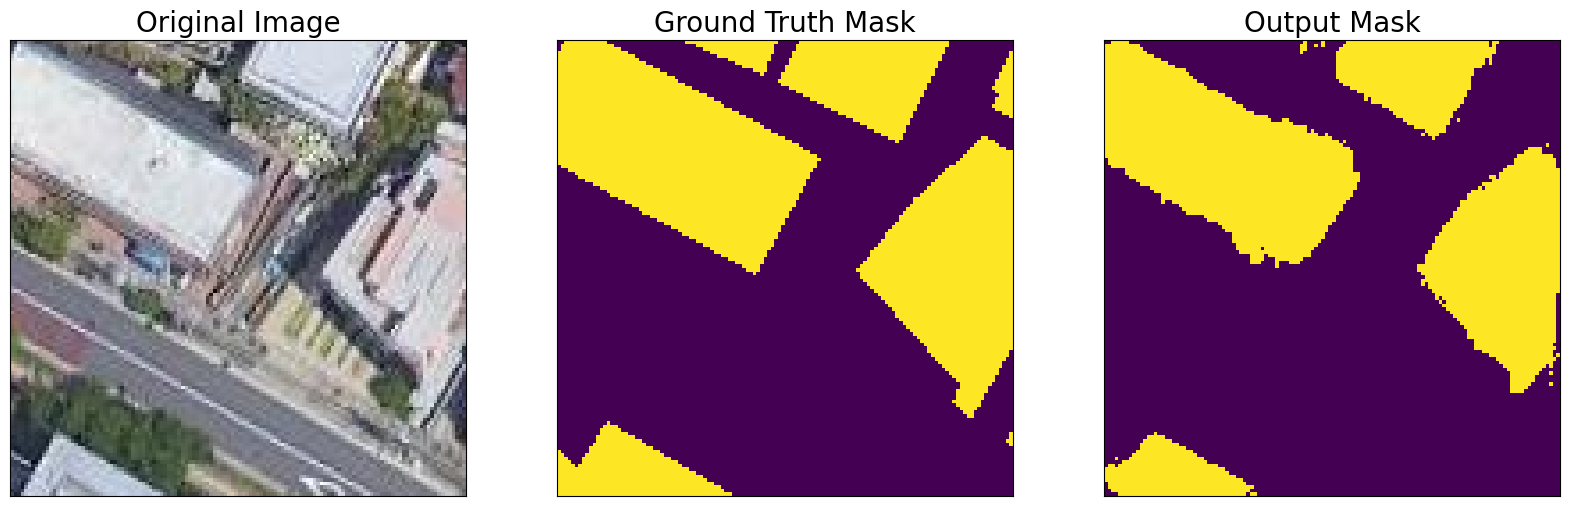

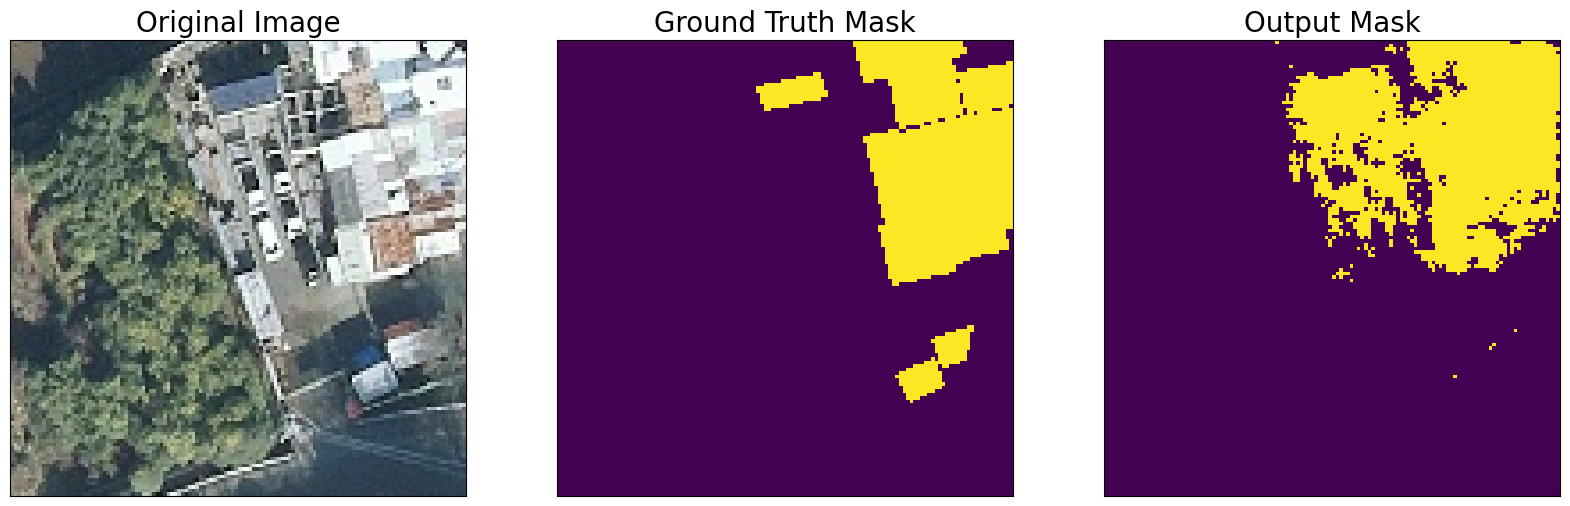

Epoch 17/30, Train Loss: 0.9527, Val Loss: 0.9172, Train IOU: 0.8485859412837226, Valid IOU: 0.8546136305700495


Epoch 18/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9746665104870413  iou_score: 0.8276109838557624


Epoch 18/30 (Train): 59batch [01:49,  1.86s/batch]
Epoch 18/30 (Train): 59batch [01:49,  1.86s/batch]
Epoch 18/30 (Train): 59batch [01:50,  1.87s/batch]
Epoch 18/30 (Train): 59batch [01:49,  1.85s/batch]
Epoch 18/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.8704797168692989  iou_score: 0.8650301617776923

Epoch 18/30 (Train): 1batch [00:00,  2.71batch/s]

Epoch 18/30 (Train): 14batch [00:01, 13.84batch/s]



Epoch 19/30 (Train): 0batch [00:00, ?batch/s]

Epoch 18/30, Train Loss: 0.9487, Val Loss: 0.9033, Train IOU: 0.848133519605703, Valid IOU: 0.8591024047065284


Epoch 19/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9506253752358544  iou_score: 0.8431125843372235


Epoch 19/30 (Train): 59batch [01:44,  1.77s/batch]
Epoch 19/30 (Train): 59batch [01:51,  1.88s/batch]
Epoch 19/30 (Train): 59batch [01:52,  1.90s/batch]
Epoch 19/30 (Train): 59batch [01:51,  1.89s/batch]
Epoch 19/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.88162485292492  iou_score: 0.8599174396272233

Epoch 19/30 (Train): 1batch [00:00,  5.37batch/s]

Epoch 19/30 (Train): 14batch [00:00, 25.13batch/s]

Epoch 19/30 (Train): 14batch [00:00, 23.15batch/s]



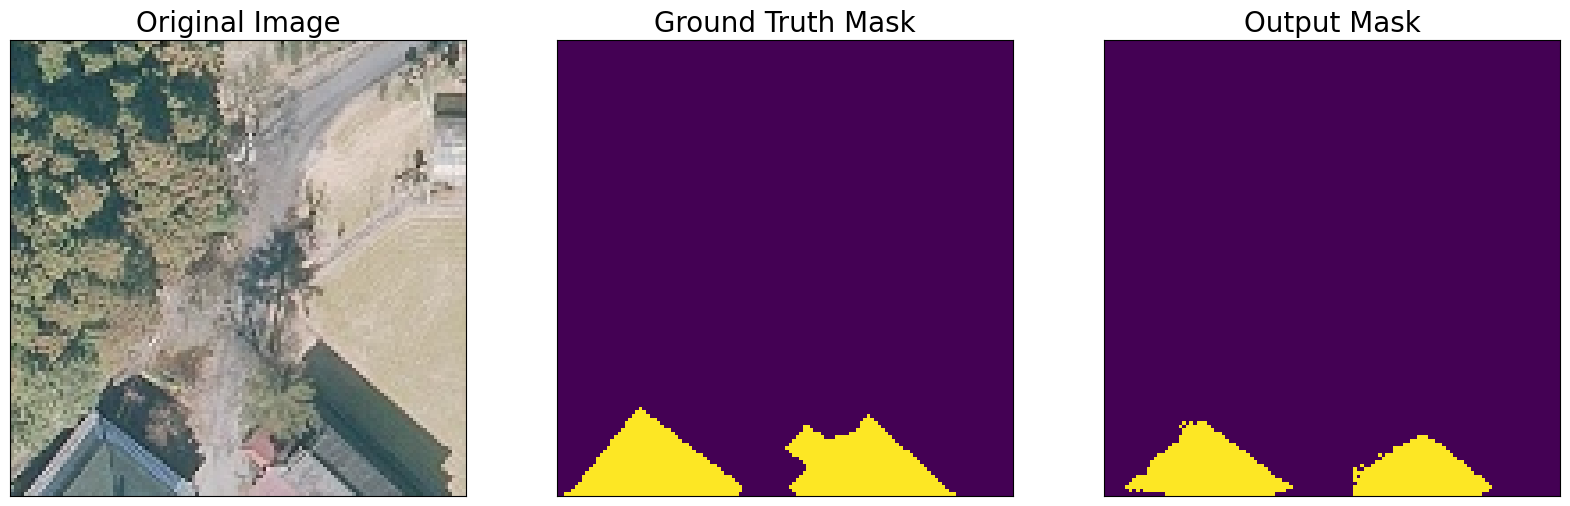

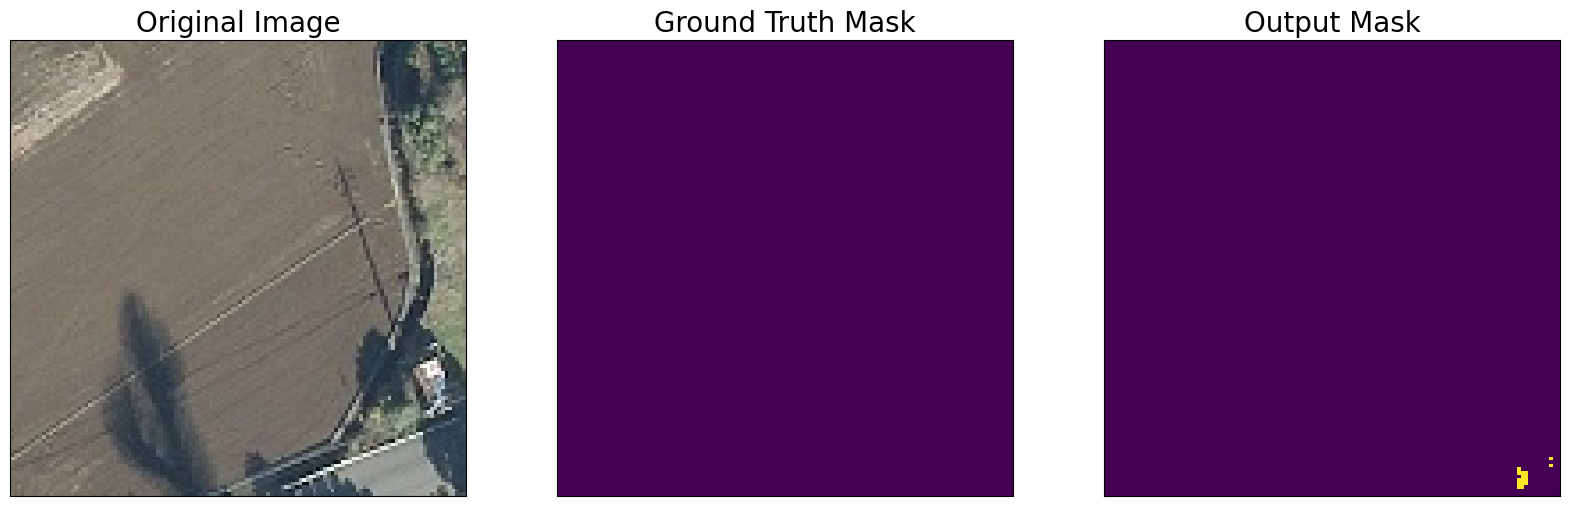

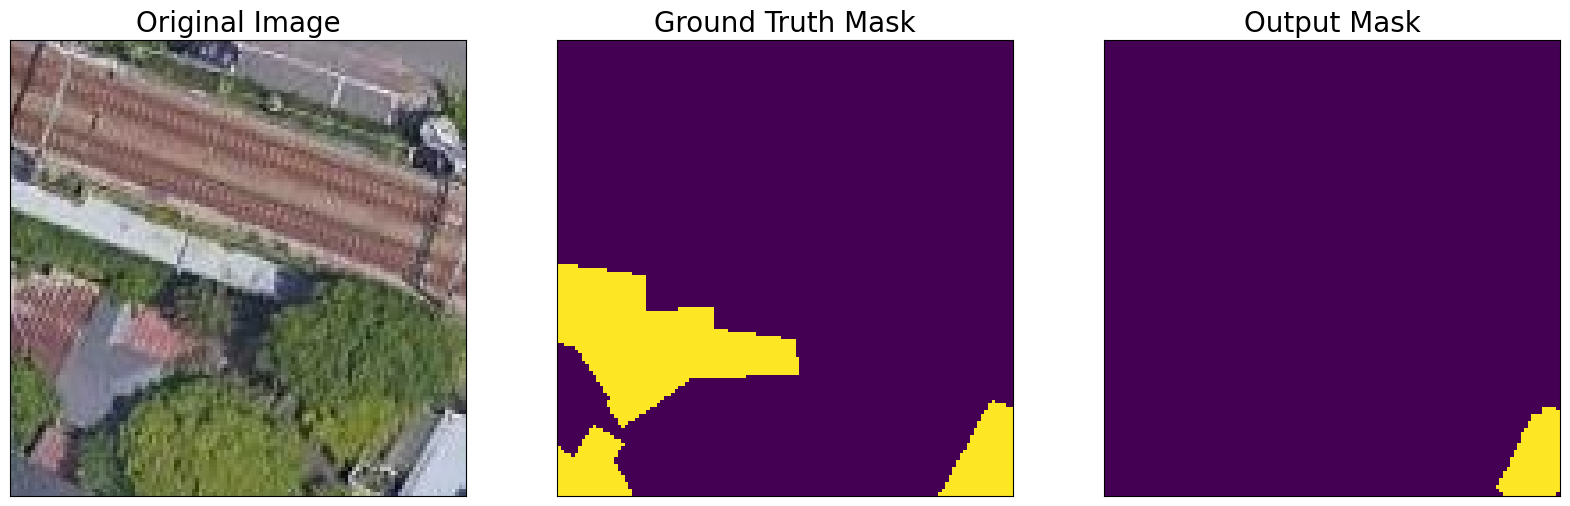

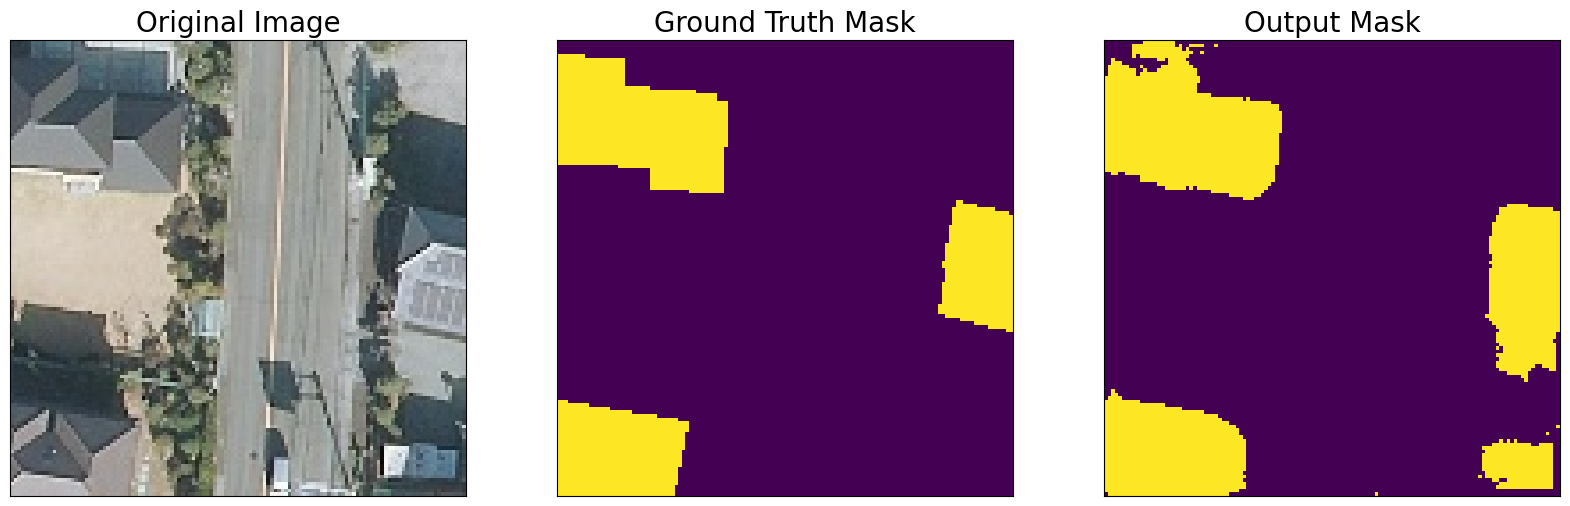

Epoch 19/30, Train Loss: 0.9480, Val Loss: 0.9164, Train IOU: 0.8493621148053009, Valid IOU: 0.8549886957075316


Epoch 20/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.8915433295752283  iou_score: 0.8574232706659952


Epoch 20/30 (Train): 59batch [01:43,  1.75s/batch]
Epoch 20/30 (Train): 59batch [01:43,  1.75s/batch]
Epoch 20/30 (Train): 59batch [01:43,  1.75s/batch]
Epoch 20/30 (Train): 59batch [01:43,  1.75s/batch]
Epoch 20/30 (Train): 1batch [00:00,  6.78batch/s]

Train_Batch: 0, loss: 0.8771593235289115  iou_score: 0.8645895606288884


Epoch 20/30 (Train): 14batch [00:00, 25.17batch/s]





Epoch 20/30, Train Loss: 0.9357, Val Loss: 0.9296, Train IOU: 0.8522932209835115, Valid IOU: 0.8522137934447418


Epoch 21/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9931740132156162  iou_score: 0.8199079299668979


Epoch 21/30 (Train): 59batch [01:40,  1.71s/batch]
Epoch 21/30 (Train): 59batch [01:39,  1.69s/batch]
Epoch 21/30 (Train): 59batch [01:40,  1.70s/batch]
Epoch 21/30 (Train): 59batch [01:39,  1.68s/batch]
Epoch 21/30 (Train): 1batch [00:00,  5.64batch/s]

Train_Batch: 0, loss: 0.8852485518840008  iou_score: 0.8613717733570758


Epoch 21/30 (Train): 14batch [00:00, 25.15batch/s]





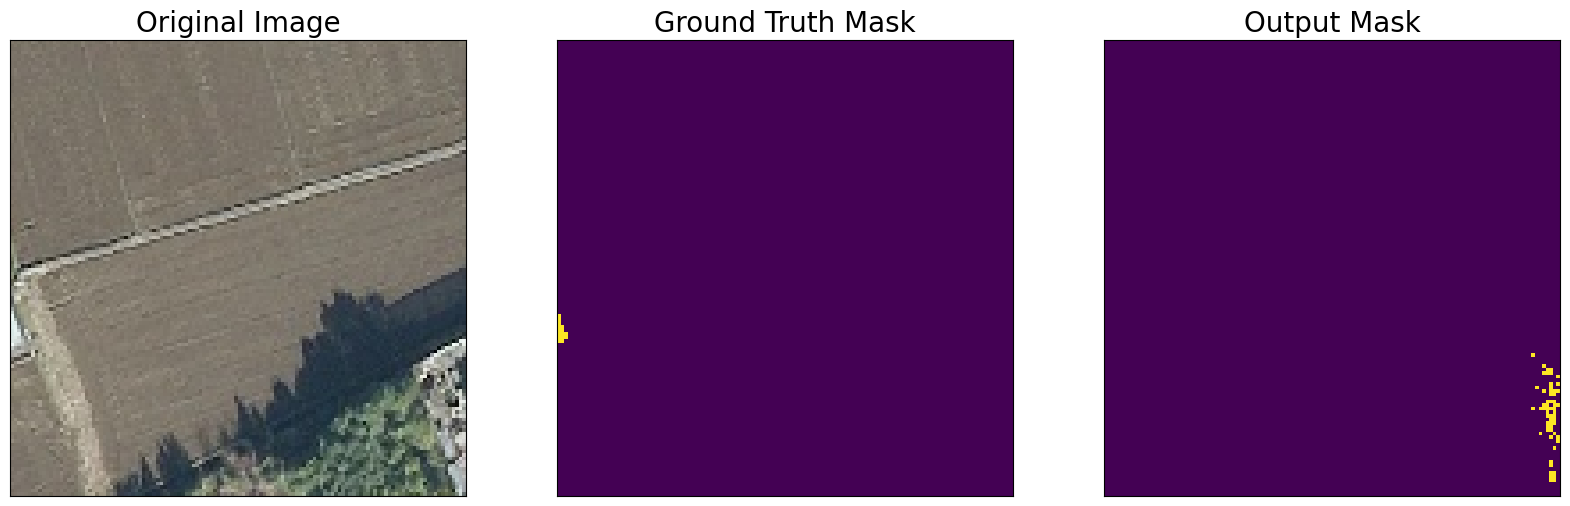

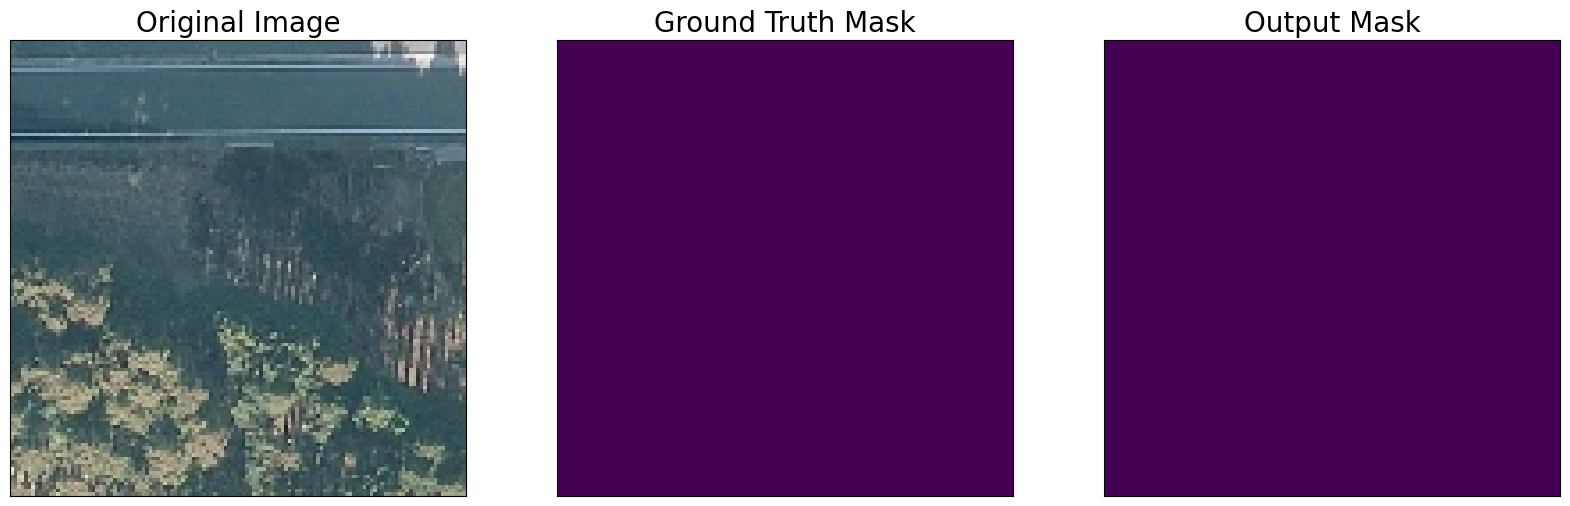

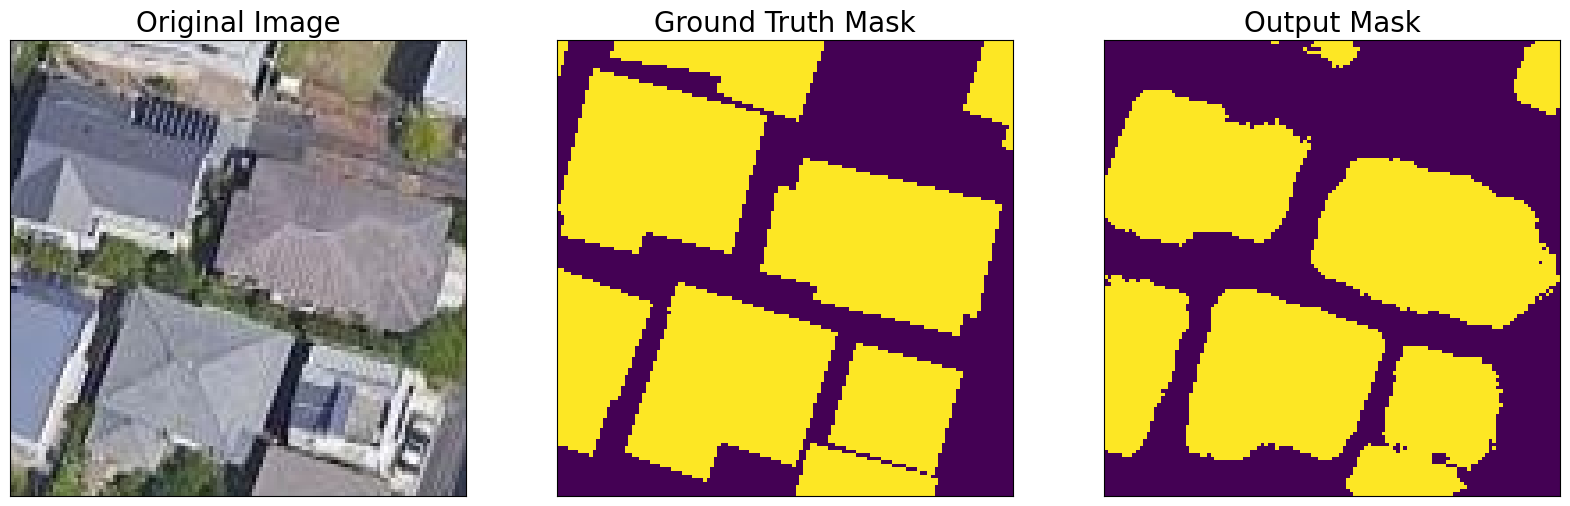

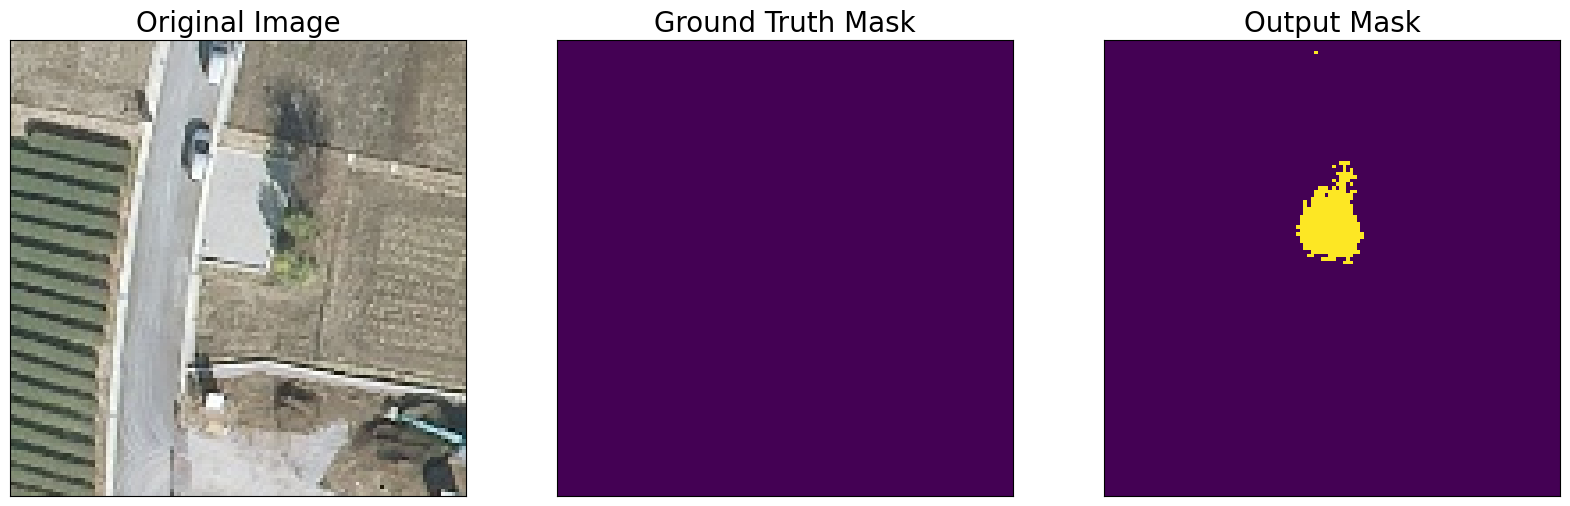

Epoch 21/30, Train Loss: 0.9623, Val Loss: 0.9282, Train IOU: 0.8457637282437219, Valid IOU: 0.8500497237951992


Epoch 22/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.8990272590913269  iou_score: 0.8691314518397839


Epoch 22/30 (Train): 59batch [01:40,  1.70s/batch]
Epoch 22/30 (Train): 59batch [01:39,  1.69s/batch]
Epoch 22/30 (Train): 59batch [01:41,  1.72s/batch]
Epoch 22/30 (Train): 59batch [01:40,  1.70s/batch]
Epoch 22/30 (Train): 1batch [00:00,  7.30batch/s]

Train_Batch: 0, loss: 0.9122543802970249  iou_score: 0.8567201670051743


Epoch 22/30 (Train): 14batch [00:00, 21.16batch/s]
Epoch 22/30 (Train): 14batch [00:00, 23.40batch/s]




Epoch 22/30, Train Loss: 0.9371, Val Loss: 0.9132, Train IOU: 0.851239903120198, Valid IOU: 0.8553227105649698


Epoch 23/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9600692125107977  iou_score: 0.8438647911817933


Epoch 23/30 (Train): 59batch [02:04,  2.11s/batch]
Epoch 23/30 (Train): 59batch [02:05,  2.12s/batch]
Epoch 23/30 (Train): 59batch [02:05,  2.12s/batch]
Epoch 23/30 (Train): 59batch [02:05,  2.13s/batch]
Epoch 23/30 (Train): 1batch [00:00,  1.52batch/s]

Train_Batch: 0, loss: 0.8859161017093802  iou_score: 0.8648949716321864

Epoch 23/30 (Train): 1batch [00:00,  1.84batch/s]

Epoch 23/30 (Train): 14batch [00:00, 24.95batch/s]





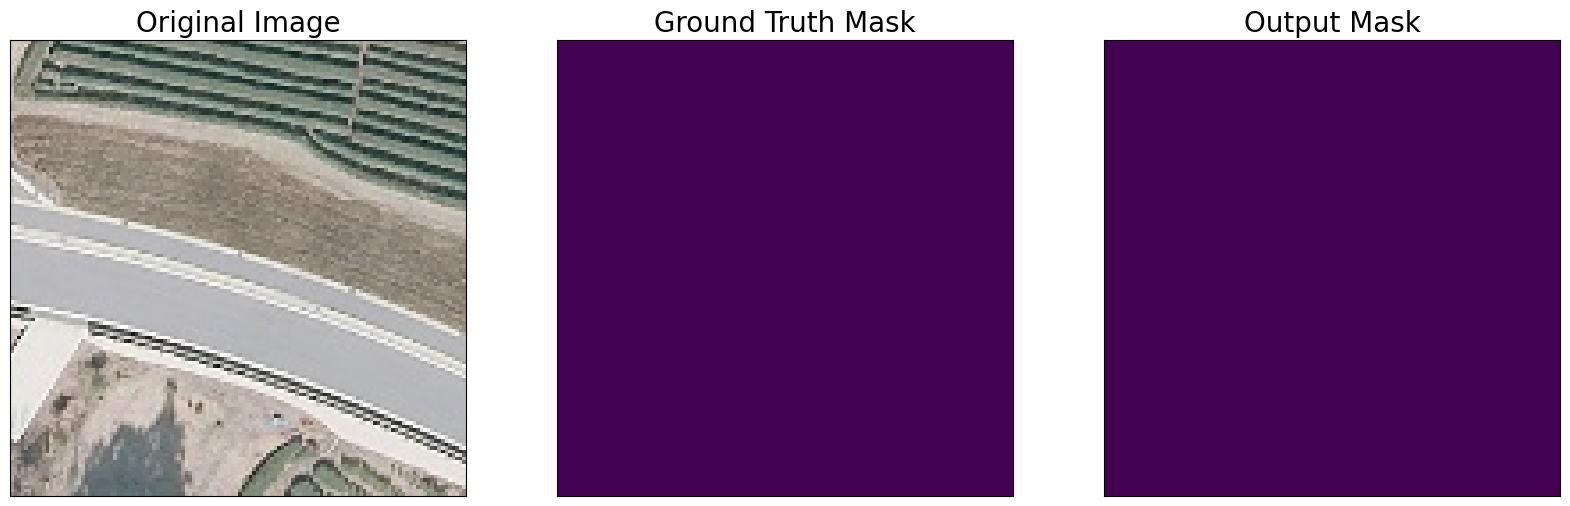

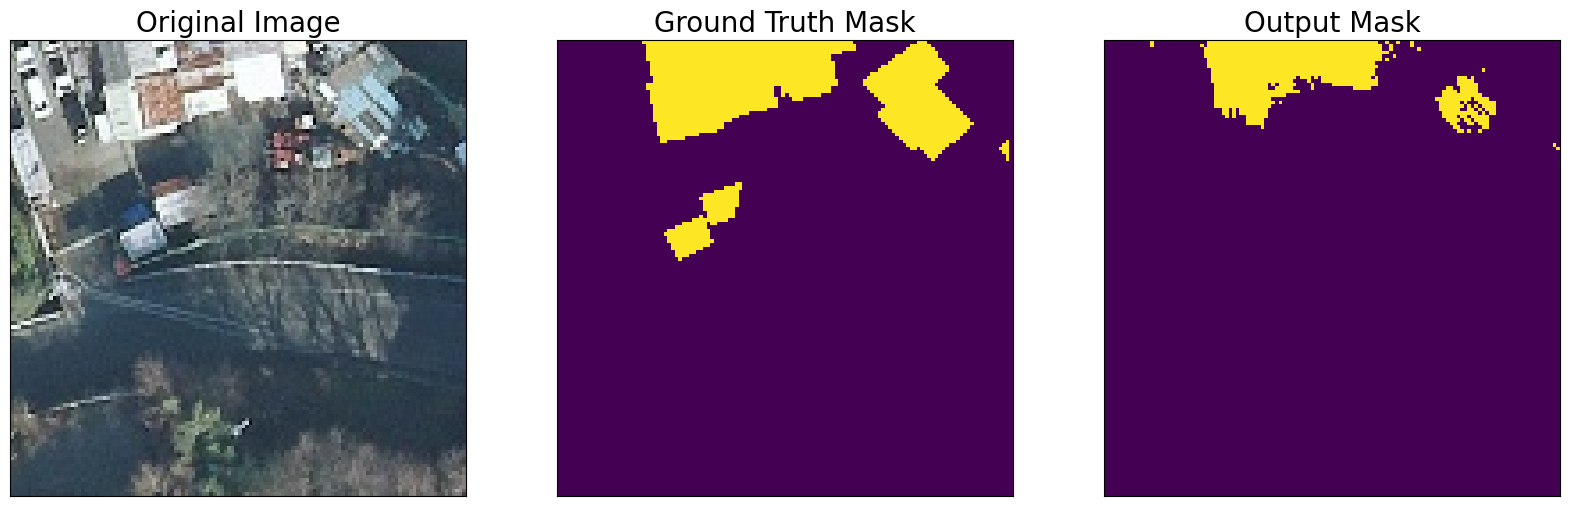

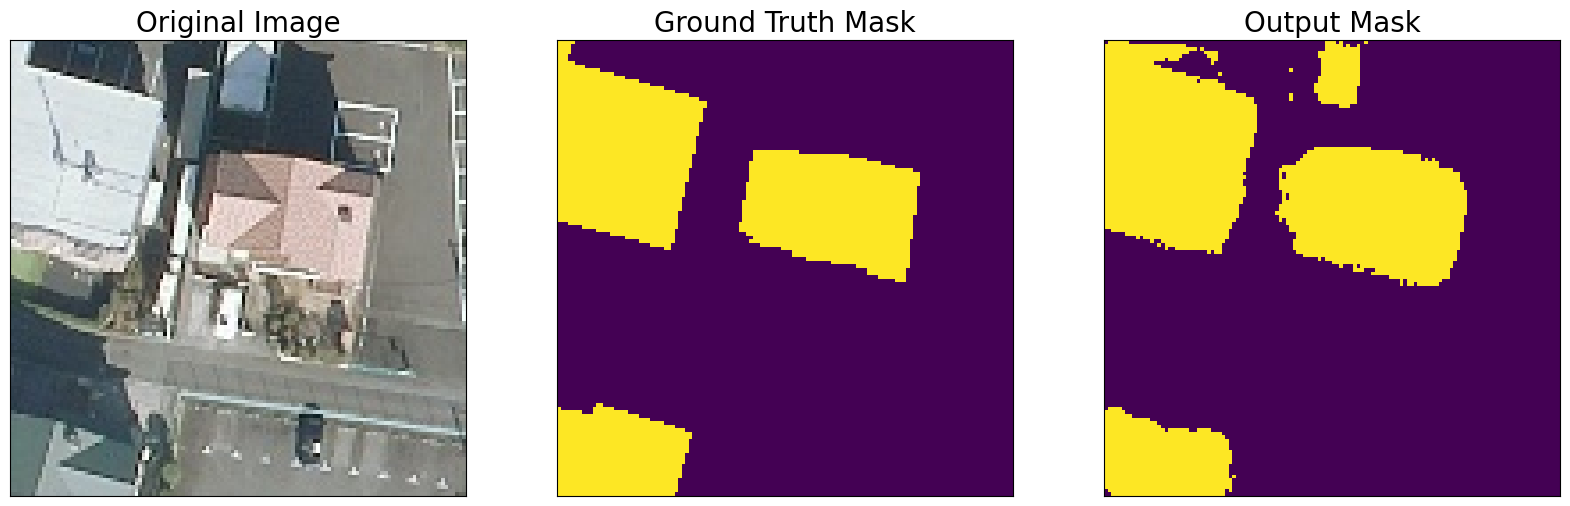

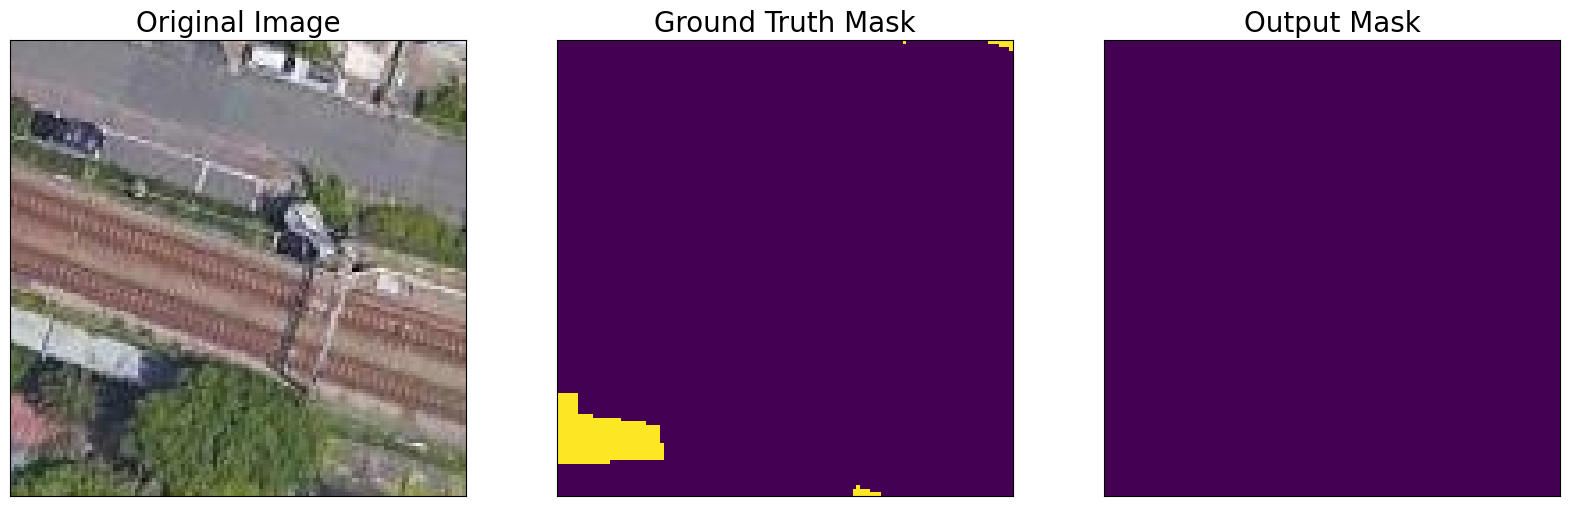

Epoch 24/30 (Train): 0batch [00:00, ?batch/s]

Epoch 23/30, Train Loss: 0.9487, Val Loss: 0.8880, Train IOU: 0.847856390341141, Valid IOU: 0.8603079433271204


Epoch 24/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9828063605447489  iou_score: 0.8325375948465435


Epoch 24/30 (Train): 59batch [01:47,  1.83s/batch]
Epoch 24/30 (Train): 59batch [01:40,  1.71s/batch]
Epoch 24/30 (Train): 59batch [01:48,  1.84s/batch]
Epoch 24/30 (Train): 59batch [01:47,  1.82s/batch]
Epoch 24/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.8233541106351536  iou_score: 0.8758329861668633

Epoch 24/30 (Train): 1batch [00:00,  6.08batch/s]

Epoch 24/30 (Train): 14batch [00:00, 21.35batch/s]





Epoch 24/30, Train Loss: 0.9395, Val Loss: 0.9042, Train IOU: 0.8505643085086865, Valid IOU: 0.8598653153957703


Epoch 25/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.8789787220622524  iou_score: 0.8578938938348117


Epoch 25/30 (Train): 59batch [01:43,  1.75s/batch]
Epoch 25/30 (Train): 59batch [01:43,  1.76s/batch]
Epoch 25/30 (Train): 59batch [01:43,  1.75s/batch]
Epoch 25/30 (Train): 59batch [01:44,  1.77s/batch]
Epoch 25/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.8245837643325805  iou_score: 0.8826510938531917

Epoch 25/30 (Train): 1batch [00:00,  1.18batch/s]

Epoch 25/30 (Train): 14batch [00:00, 23.74batch/s]





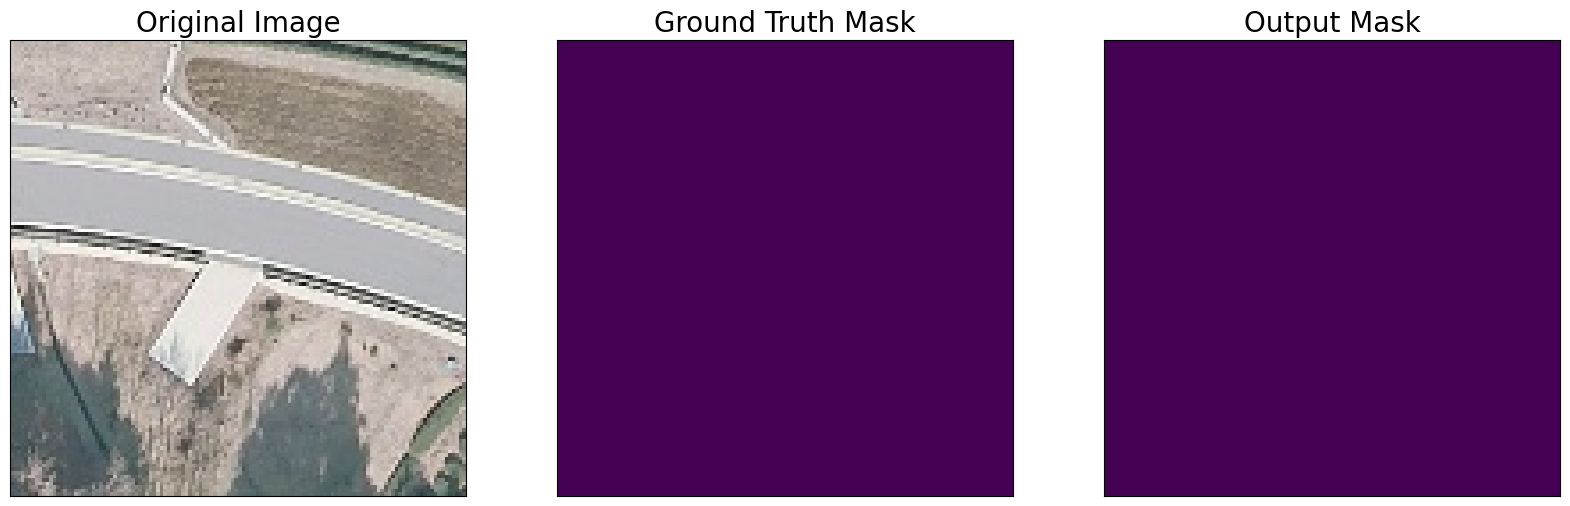

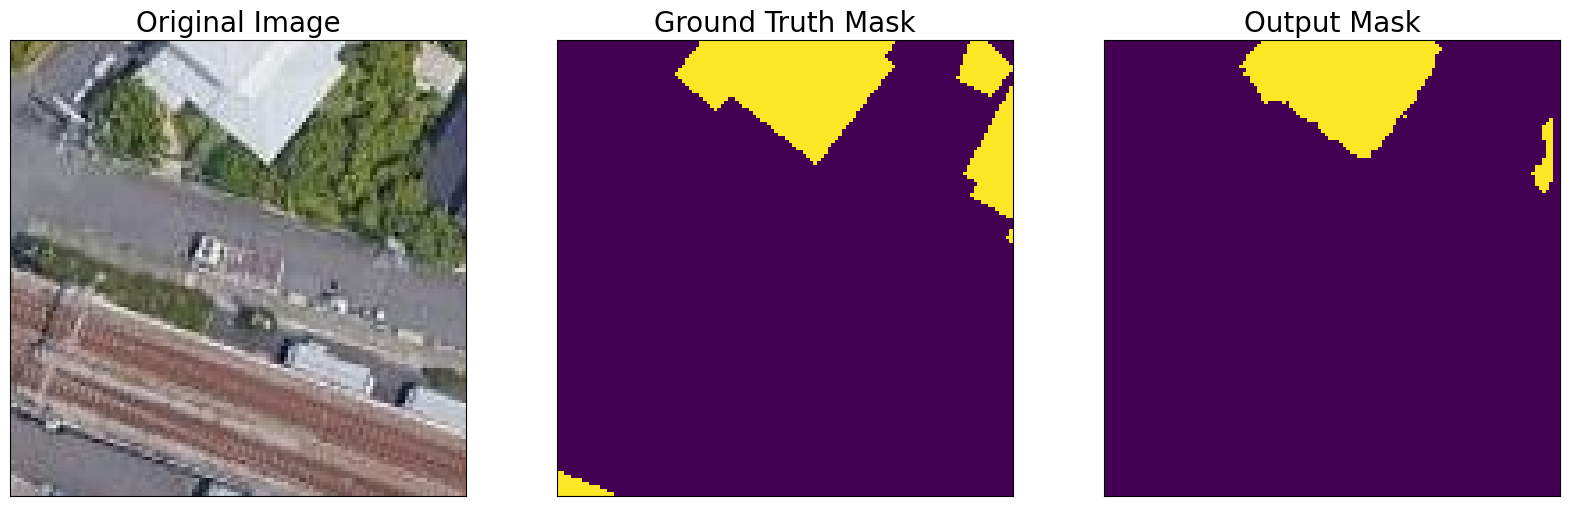

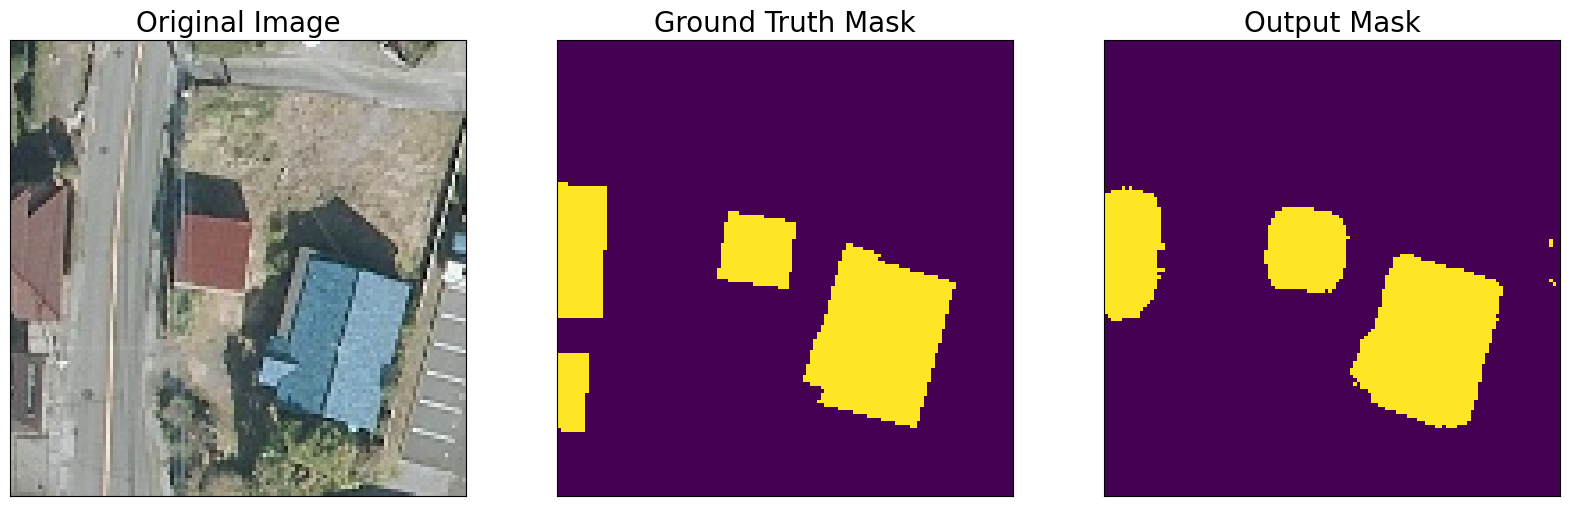

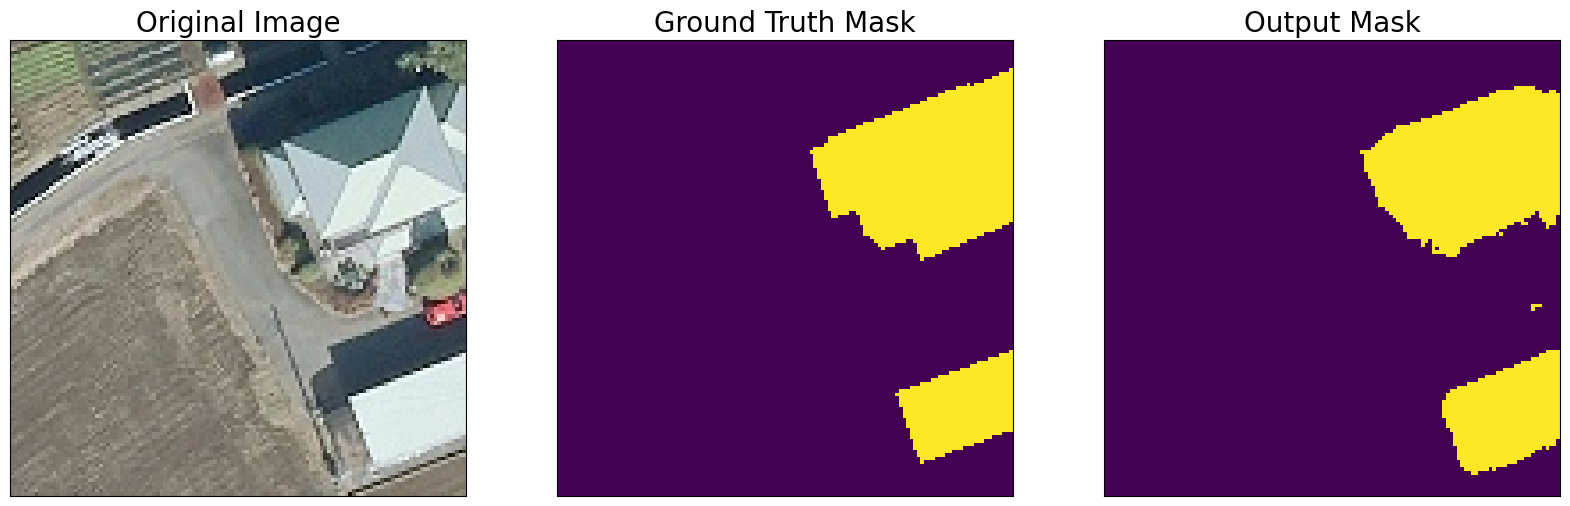

Epoch 26/30 (Train): 0batch [00:00, ?batch/s]

Epoch 25/30, Train Loss: 0.9492, Val Loss: 0.8925, Train IOU: 0.8474255723600654, Valid IOU: 0.8610149694308057


Epoch 26/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9239245305352899  iou_score: 0.8466049495081001


Epoch 26/30 (Train): 59batch [01:54,  1.94s/batch]
Epoch 26/30 (Train): 59batch [01:59,  2.03s/batch]
Epoch 26/30 (Train): 59batch [02:00,  2.04s/batch]
Epoch 26/30 (Train): 59batch [02:00,  2.04s/batch]
Epoch 26/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.8253112621718384  iou_score: 0.8762407914784729

Epoch 26/30 (Train): 1batch [00:00,  6.44batch/s]

Epoch 26/30 (Train): 14batch [00:00, 21.16batch/s]





Epoch 26/30, Train Loss: 0.9571, Val Loss: 0.9018, Train IOU: 0.8460896381548704, Valid IOU: 0.8573664398232594


Epoch 27/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.8770385792031403  iou_score: 0.8617489611269185


Epoch 27/30 (Train): 59batch [01:41,  1.64s/batch]
Epoch 27/30 (Train): 59batch [01:41,  1.73s/batch]
Epoch 27/30 (Train): 59batch [01:42,  1.73s/batch]
Epoch 27/30 (Train): 59batch [01:41,  1.73s/batch]
Epoch 27/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9033777069262969  iou_score: 0.852900426730073

Epoch 27/30 (Train): 1batch [00:00,  6.55batch/s]

Epoch 27/30 (Train): 14batch [00:00, 25.02batch/s]





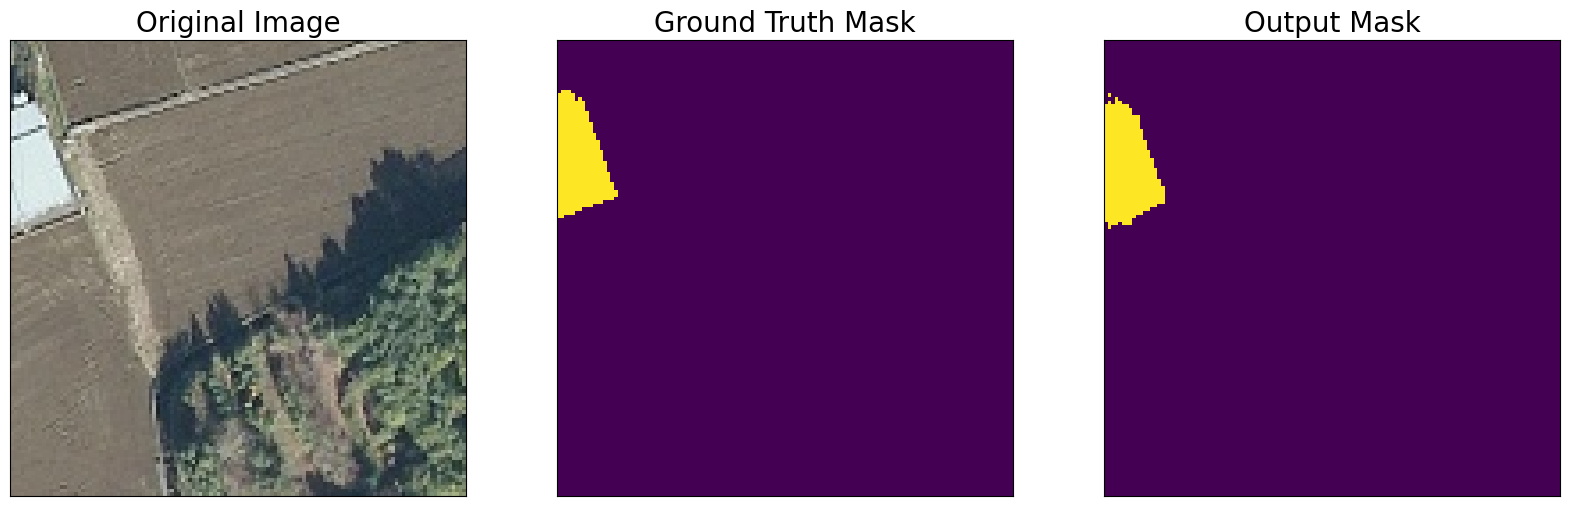

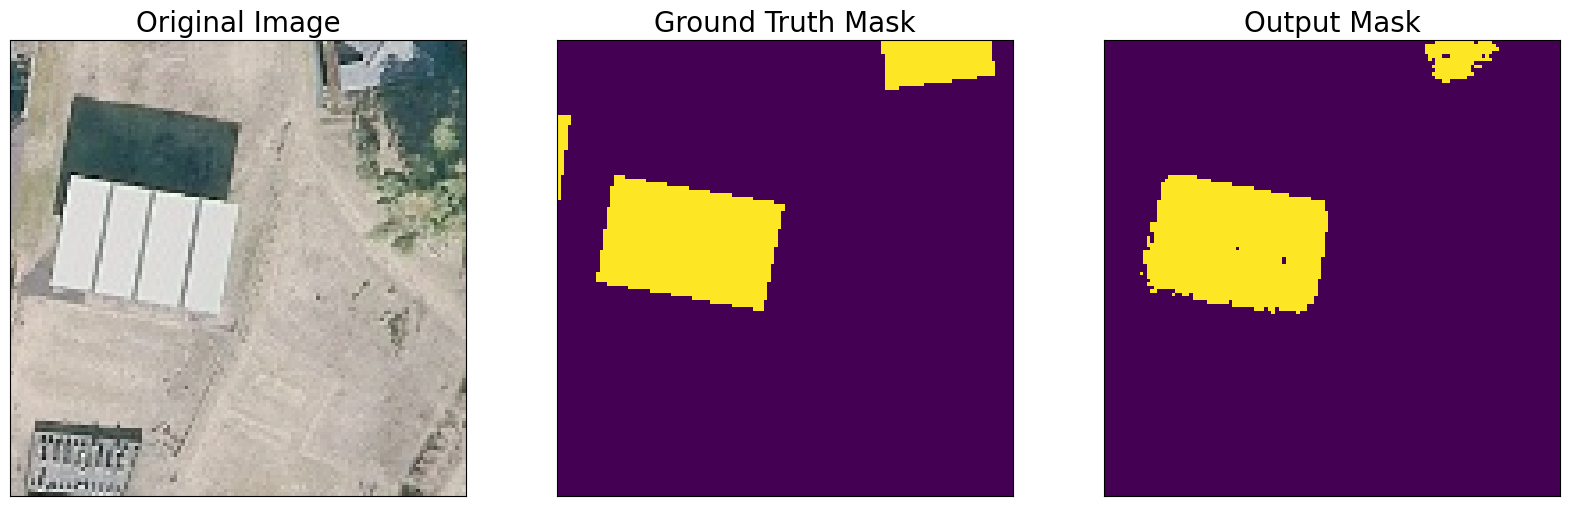

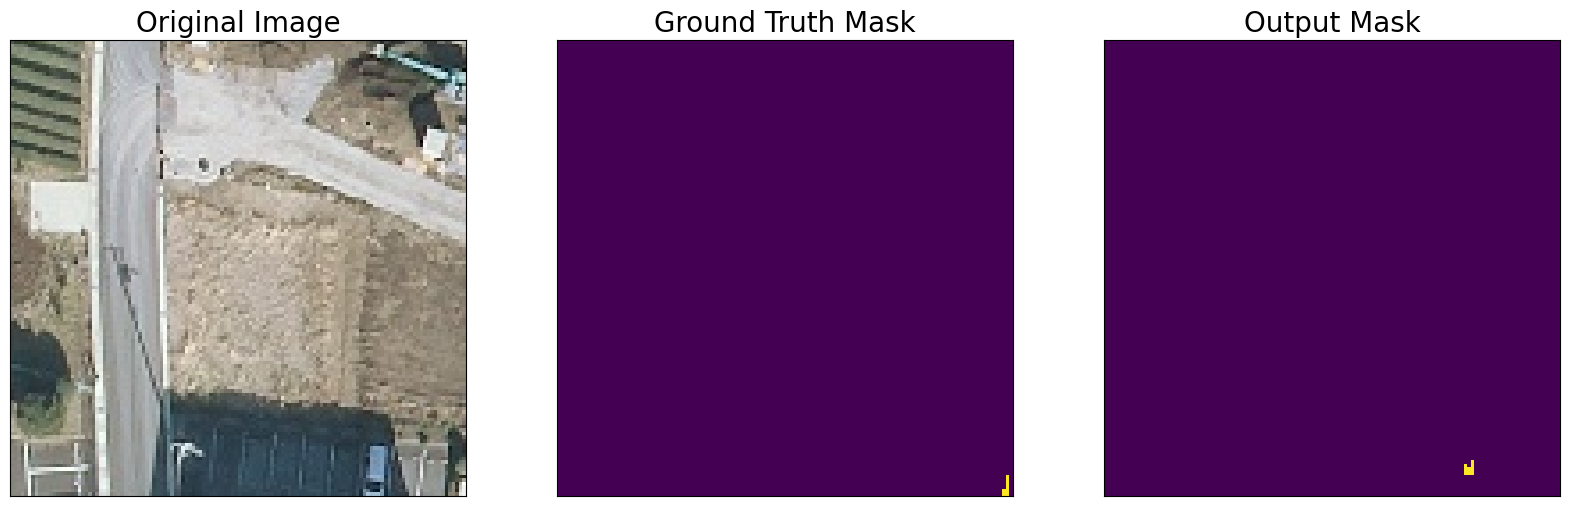

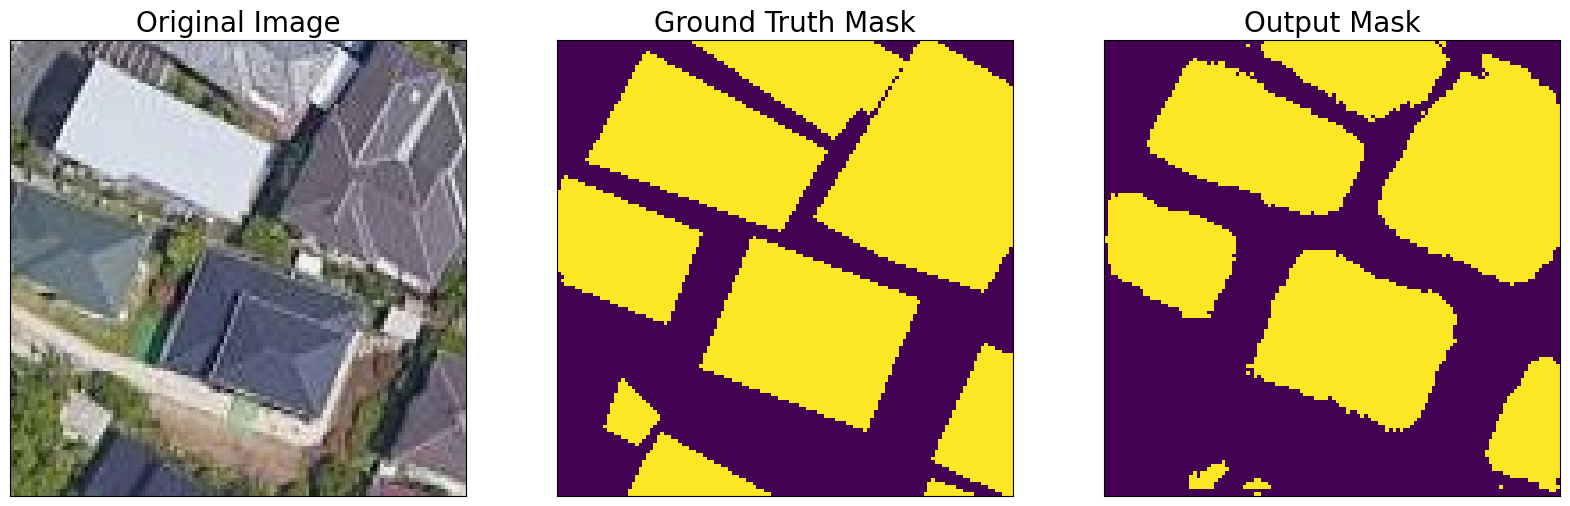

Epoch 28/30 (Train): 0batch [00:00, ?batch/s]

Epoch 27/30, Train Loss: 0.9496, Val Loss: 0.8783, Train IOU: 0.8468275948877106, Valid IOU: 0.8638019239966466


Epoch 28/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9497551444626522  iou_score: 0.8382438980568716


Epoch 28/30 (Train): 59batch [01:40,  1.70s/batch]
Epoch 28/30 (Train): 59batch [01:46,  1.64s/batch]
Epoch 28/30 (Train): 59batch [01:46,  1.81s/batch]
Epoch 28/30 (Train): 59batch [01:47,  1.83s/batch]
Epoch 28/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9026049769699209  iou_score: 0.856505185429389


Epoch 28/30 (Train): 14batch [00:00, 25.42batch/s]





Epoch 28/30, Train Loss: 0.9417, Val Loss: 0.9159, Train IOU: 0.8504601394759406, Valid IOU: 0.8557728888988361


Epoch 29/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 1.0121393210799443  iou_score: 0.8094376399745283


Epoch 29/30 (Train): 59batch [01:41,  1.73s/batch]
Epoch 29/30 (Train): 59batch [01:41,  1.72s/batch]
Epoch 29/30 (Train): 59batch [01:41,  1.72s/batch]
Epoch 29/30 (Train): 59batch [01:39,  1.69s/batch]
Epoch 29/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9091475396240893  iou_score: 0.8521708251643327

Epoch 29/30 (Train): 1batch [00:00,  4.87batch/s]

Epoch 29/30 (Train): 14batch [00:00, 25.25batch/s]


Epoch 29/30 (Train): 14batch [00:00, 23.45batch/s]


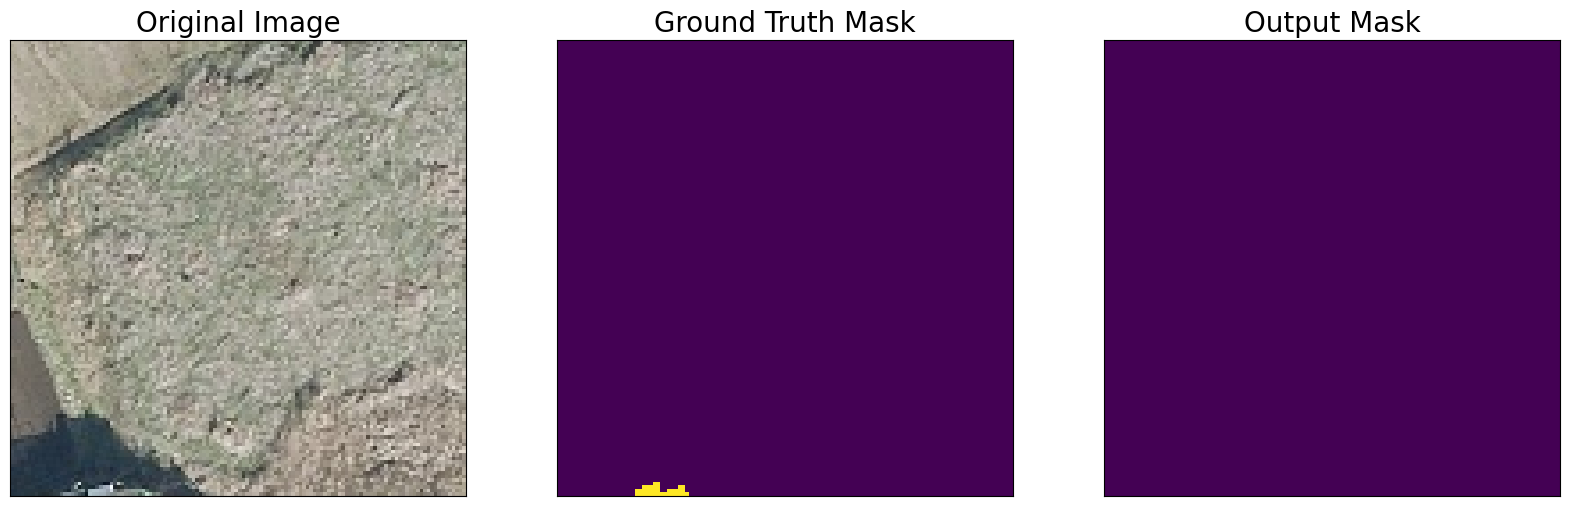

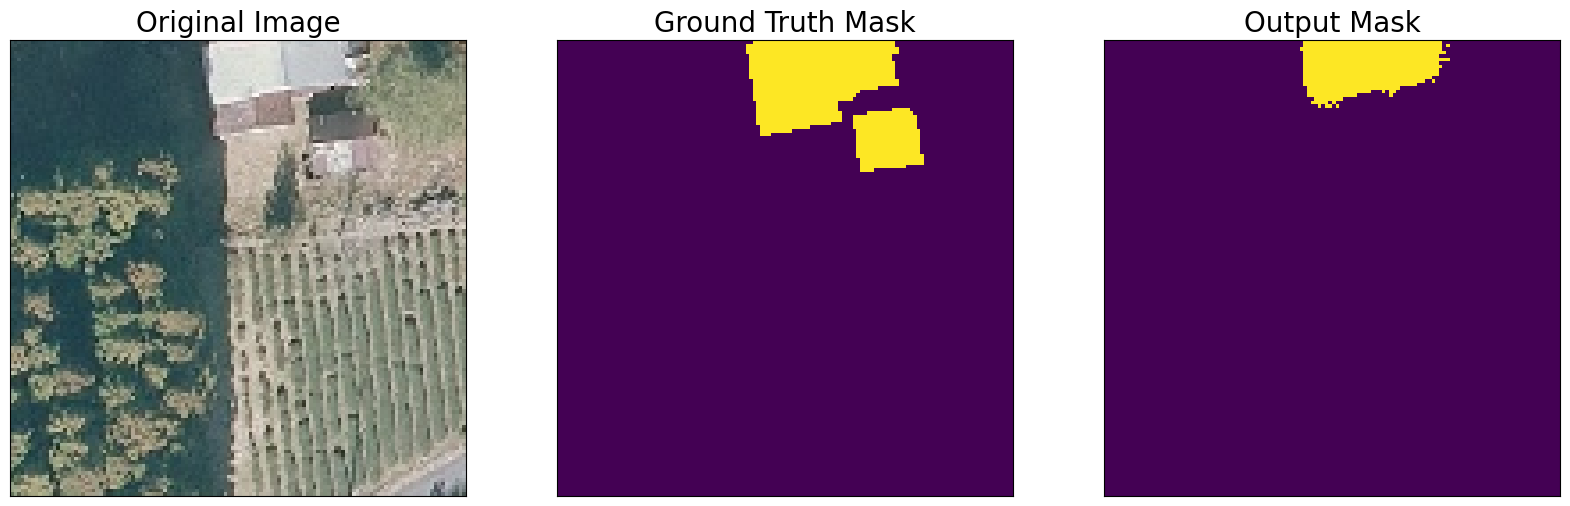

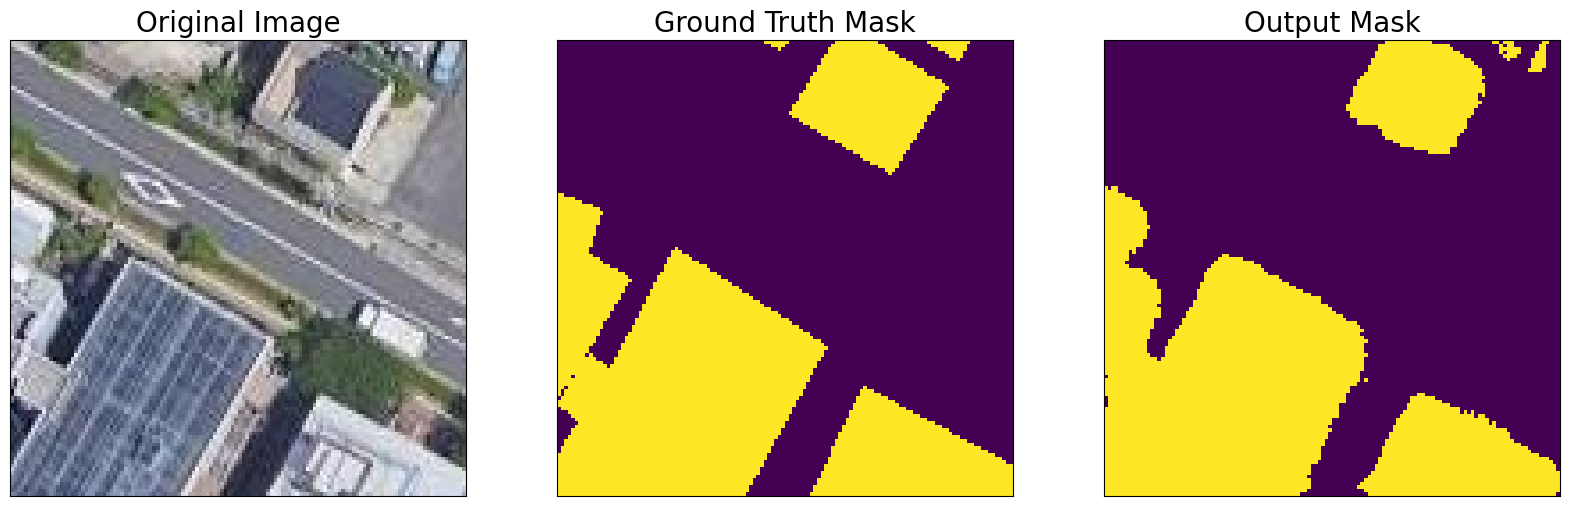

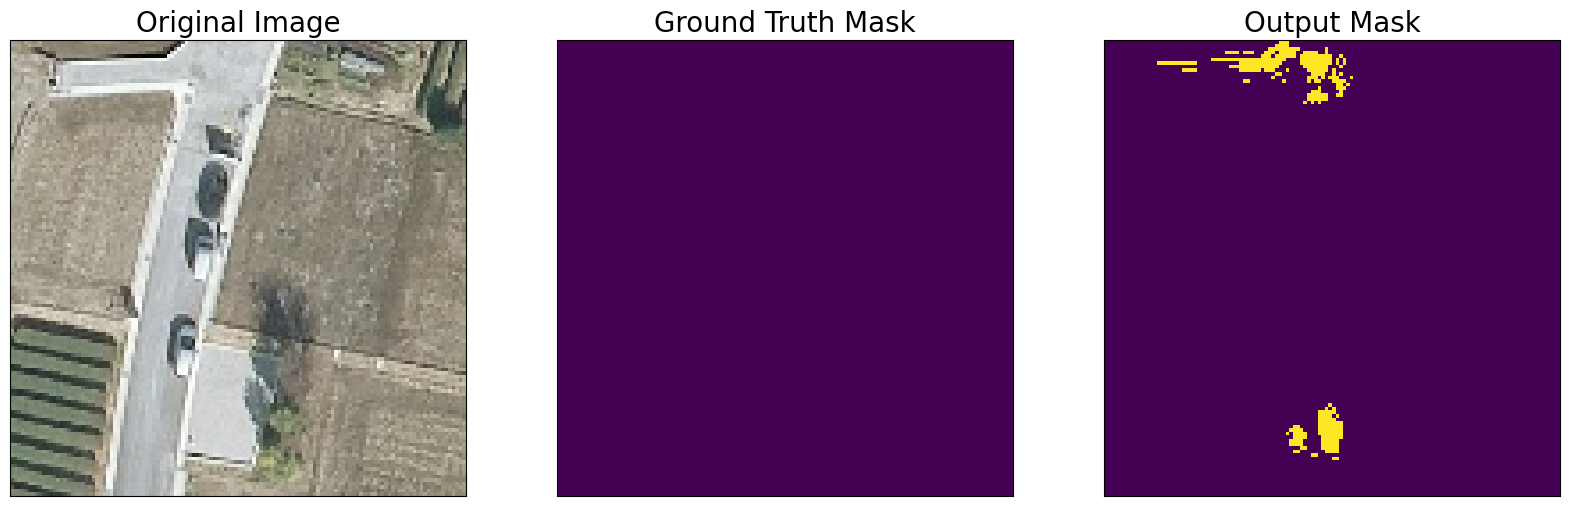

Epoch 29/30, Train Loss: 0.9586, Val Loss: 0.8942, Train IOU: 0.8442447203692182, Valid IOU: 0.8574812226195094


Epoch 30/30 (Train): 0batch [00:00, ?batch/s]

Train_Batch: 0, loss: 0.9340108799933593  iou_score: 0.8447820073921679


Epoch 30/30 (Train): 52batch [01:40,  2.14s/batch]

In [ ]:
from tqdm import tqdm
def train_function(model, epochs):
    criterion = MixedLoss(10.0, 2.0)
    train_dataloader, test_dataloader = data()
    length = train_dataloader.__len__()
    lr = 0.00001
    
    num_train_steps = int(
        length / 16 / xm.xrt_world_size() * epochs
    )

    lr = lr * xm.xrt_world_size()
    xm.master_print('kalua')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.05)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )

    
    xm.master_print(f'num_training_steps = {num_train_steps}, world_size={xm.xrt_world_size()}')
    device = xm.xla_device()
    model = model.to(device)
    best_iou = 0.0
    train_loss = []
    valid_loss = []
    for epoch in range(epochs):
        gc.collect()
        para_loader = pl.ParallelLoader(train_dataloader, [device])
        train_loader = para_loader.per_device_loader(device)

        val_loader = pl.ParallelLoader(test_dataloader, [device])
        valid_loader = val_loader.per_device_loader(device)
        
        trn_loss, val_loss, train_iou, valid_iou = train_one_epoch(epoch, epochs, model, train_loader, valid_loader, criterion, scheduler, device, optimizer)
        
        scheduler.step()
        train_loss.append(trn_loss)
        valid_loss.append(val_loss)
        gc.collect()

        if best_iou < valid_iou:
            best_iou = valid_iou
            xm.save(model.state_dict(), f'./best_unet_model.pth')
        
        xm.master_print(f'Epoch {epoch+1}/{epochs}, Train Loss: {trn_loss:.4f}, Val Loss: {val_loss:.4f}, Train IOU: {train_iou}, Valid IOU: {valid_iou}')
        with open('losses.txt', 'a') as f:
            f.write(f'Epoch {epoch+1}/{epochs}, Train Loss: {trn_loss:.4f}, Val Loss: {val_loss:.4f},  Train IOU: {train_iou}, Valid IOU: {valid_iou}\n')
        
    xm.rendezvous('save_model')
    xm.master_print('save model')
    xm.save(model.state_dict(), f'./final_unet_model.pth')


def _mp_fn(rank, flags):
    try:
        model = UNetWithResnet50Encoder()
        dev = xm.xla_device()
        model = model.to(dev)
        # dataloader_train, dataloader_test, length = data()
        torch.set_default_tensor_type('torch.FloatTensor')
        train_function(model, epochs=30)

    except Exception as e:
        print(f"Exception in process {rank}: {e}")
        raise

if __name__ == '__main__':
    FLAGS = {}
    try:
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=4, start_method='fork')
    except Exception as e:
        print(f"Exception in main: {e}")

In [ ]:
# """ Parts of the U-Net model """

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class DoubleConv(nn.Module):
#     """(convolution => [BN] => ReLU) * 2"""

#     def __init__(self, in_channels, out_channels, mid_channels=None):
#         super().__init__()
#         if not mid_channels:
#             mid_channels = out_channels
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(mid_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.double_conv(x)


# class Down(nn.Module):
#     """Downscaling with maxpool then double conv"""

#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.maxpool_conv = nn.Sequential(
#             nn.MaxPool2d(2),
#             DoubleConv(in_channels, out_channels)
#         )

#     def forward(self, x):
#         return self.maxpool_conv(x)


# class Up(nn.Module):
#     """Upscaling then double conv"""

#     def __init__(self, in_channels, out_channels, bilinear=True):
#         super().__init__()

#         # if bilinear, use the normal convolutions to reduce the number of channels
#         if bilinear:
#             self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#             self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
#         else:
#             self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
#             self.conv = DoubleConv(in_channels, out_channels)

#     def forward(self, x1, x2):
#         x1 = self.up(x1)
#         # input is CHW
#         diffY = x2.size()[2] - x1.size()[2]
#         diffX = x2.size()[3] - x1.size()[3]

#         x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
#                         diffY // 2, diffY - diffY // 2])
#         # if you have padding issues, see
#         # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
#         # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
#         x = torch.cat([x2, x1], dim=1)
#         return self.conv(x)


# class OutConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(OutConv, self).__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

#     def forward(self, x):
#         return self.conv(x)
# # from .unet_parts import *


# class UNet(nn.Module):
#     def __init__(self, n_channels, n_classes, bilinear=False):
#         super(UNet, self).__init__()
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.bilinear = bilinear

#         self.inc = (DoubleConv(n_channels, 64))
#         self.down1 = (Down(64, 128))
#         self.down2 = (Down(128, 256))
#         self.down3 = (Down(256, 512))
#         factor = 2 if bilinear else 1
#         self.down4 = (Down(512, 1024 // factor))
#         self.up1 = (Up(1024, 512 // factor, bilinear))
#         self.up2 = (Up(512, 256 // factor, bilinear))
#         self.up3 = (Up(256, 128 // factor, bilinear))
#         self.up4 = (Up(128, 64, bilinear))
#         self.outc = (OutConv(64, n_classes))

#     def forward(self, x):
#         x1 = self.inc(x)
#         x2 = self.down1(x1)
#         x3 = self.down2(x2)
#         x4 = self.down3(x3)
#         x5 = self.down4(x4)
#         x = self.up1(x5, x4)
#         x = self.up2(x, x3)
#         x = self.up3(x, x2)
#         x = self.up4(x, x1)
#         logits = self.outc(x)
#         return logits
# model = UNet(3, 1)
# # model = Unet()
# import torchvision
# from torchview import draw_graph
# import graphviz
# graphviz.set_jupyter_format('png')

# model_graph = draw_graph(model, input_size=(1,3,512,512))
# model_graph.visual_graph